<a href="https://colab.research.google.com/github/mardocheeogecime-gif/Rede_Colabora-o_Acad-mica_ECI_UFMG/blob/main/deeplearning_produ_o_cientifica_ufmg_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ----------------------------------------
# CÉLULA 1: Instalações, Funções e Configuração de Aceleração
# ----------------------------------------
!pip install requests tqdm pandas openpyxl --quiet
import csv, json, sys, time, urllib.parse
import re # Essencial para extração do ano
from typing import Dict, List, Optional
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm.notebook import tqdm
import datetime
import torch # Importação para verificação de GPU

# --- Configuração de Aceleração (GPU/TPU) ---
def setup_accelerator():
    """Configura o dispositivo para GPU, TPU ou CPU."""
    if 'google.colab' in sys.modules:
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"🚀 Acelerador: **CUDA (GPU)**. Nome: {torch.cuda.get_device_name(0)}")
        else:
            # Não faz sentido verificar TPU aqui se não for usar o TF/JAX, mas a checagem é válida
            device = torch.device("cpu")
            print("⚠️ Acelerador: GPU/TPU não disponível. Usando **CPU**. Ative o runtime correto.")
    else:
        # Para ambientes locais ou outros
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        accel = "CUDA (GPU)" if device.type == 'cuda' else "CPU"
        print(f"Acelerador: {accel}")
    return device

# Executa a configuração (o dispositivo retornado não é usado na coleta OAI-PMH, mas a configuração é importante para o próximo passo de DL)
DEVICE = setup_accelerator()

# --- Funções de Coleta OAI-PMH (Mantidas) ---
NS = {
    'oai': 'http://www.openarchives.org/OAI/2.0/',
    'dc': 'http://purl.org/dc/elements/1.1/',
    'dcterms': 'http://purl.org/dc/terms/',
    'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/',
}

WIDE_FIELDS = [
    'OAI_Identifier','Datestamp','Title','Title_Alternative','Authors','Advisors','Referees',
    'Publisher','Type','Date','Year','Subject','Keywords','Description','Language','Format','Source',
    'Rights','URI','Identifiers','Department','Course','Collections','SetSpecs','Raw_Container'
]

def http_get(url: str, max_retries: int = 5, backoff: float = 1.5, timeout: int = 60):
    for attempt in range(max_retries):
        try:
            r = requests.get(url, timeout=timeout)
            r.raise_for_status()
            return r
        except requests.RequestException:
            if attempt == max_retries - 1:
                raise
            time.sleep(backoff ** attempt)

def build_listrecords_url(base_url: str, metadata_prefix: Optional[str] = None,
                          date_from: Optional[str] = None, date_until: Optional[str] = None,
                          set_spec: Optional[str] = None, resumption_token: Optional[str] = None) -> str:
    params = {'verb': 'ListRecords'}
    if resumption_token:
        params['resumptionToken'] = resumption_token
    else:
        if metadata_prefix: params['metadataPrefix'] = metadata_prefix
        if date_from: params['from'] = date_from
        if date_until: params['until'] = date_until
        if set_spec: params['set'] = set_spec
    return f"{base_url}?{urllib.parse.urlencode(params)}"

def localname(tag: str) -> str:
    return tag.split('}', 1)[1] if '}' in tag else tag

def text_list(elems: List[ET.Element]) -> List[str]:
    vals = []
    for e in elems:
        if e is None: continue
        t = (e.text or '').strip()
        if t: vals.append(t)
    return vals

def collect_all_dc_like(metadata_elem: ET.Element) -> Dict[str, List[str]]:
    bag: Dict[str, List[str]] = {}
    for child in metadata_elem.iter():
        if child is metadata_elem: continue
        name = localname(child.tag).lower()
        if name in ('dc','dublin_core','record'): continue
        val = (child.text or '').strip()
        if not val: continue
        bag.setdefault(name, []).append(val)
    return bag

def extract_fields_from_oai_dc(metadata_elem: ET.Element) -> Dict[str, List[str]]:
    bag: Dict[str, List[str]] = {}
    for child in metadata_elem.findall('.//dc:*', NS):
        name = localname(child.tag).lower()
        val = (child.text or '').strip()
        if not val: continue
        bag.setdefault(name, []).append(val)
    return bag

def normalize_record(header_elem: ET.Element, metadata_elem: Optional[ET.Element], metadata_prefix_used: str) -> Dict[str, str]:
    identifier = header_elem.findtext('oai:identifier', default='', namespaces=NS).strip()
    datestamp = header_elem.findtext('oai:datestamp', default='', namespaces=NS).strip()
    set_specs = text_list(header_elem.findall('oai:setSpec', NS))
    if metadata_elem is None:
        base = {k: '' for k in WIDE_FIELDS}
        base['OAI_Identifier'] = identifier
        base['Datestamp'] = datestamp
        base['SetSpecs'] = '; '.join(set_specs)
        return base
    container = list(metadata_elem)[0] if len(list(metadata_elem)) else None
    raw_container_name = ''
    bag: Dict[str, List[str]] = {}
    if container is not None:
        raw_container_name = f"{localname(container.tag)}"
        if localname(container.tag).lower() == 'dc':
            bag = extract_fields_from_oai_dc(container)
        else:
            bag = collect_all_dc_like(container)

    def get_multi(*keys) -> List[str]:
        out: List[str] = []
        for k in keys:
            vals = bag.get(k.lower(), [])
            if vals: out.extend(vals)
        seen, ordered = set(), []
        for v in out:
            if v not in seen:
                ordered.append(v); seen.add(v)
        return ordered

    titles = get_multi('title')
    alt_titles = get_multi('alternative','titlealternative','alternative-title','dcterms.alternative')
    creators = get_multi('creator','author','contributor.author')
    advisors = get_multi('contributor.advisor','advisor','orientador')
    referees = get_multi('contributor.referee','referee','banca','examiner')
    publisher = get_multi('publisher')
    types = get_multi('type')
    dates = get_multi('date','issued','available','created')
    subjects = get_multi('subject')
    keywords = get_multi('subject','keyword','keywords')
    description = get_multi('description','abstract')
    language = get_multi('language')
    fmt = get_multi('format')
    source = get_multi('source')
    rights = get_multi('rights')
    identifiers = get_multi('identifier')
    relations = get_multi('relation')
    coverage = get_multi('coverage')
    uris = [v for v in identifiers if v.startswith('http')] or get_multi('uri','identifier.uri')
    # Campos que tentam capturar Department e Course - são a chave para 'qdc'
    department = get_multi('department','publisher.department','contributor.department')
    course = get_multi('course','publisher.program','contributor.programme','degree')
    collections = get_multi('collections','set','setspec')

    # --- Extração do Ano Principal (Correção Científica) ---
    year_str = ''
    if dates:
        first_date = dates[0]
        match = re.search(r'^\d{4}', first_date)
        if match:
            year_str = match.group(0)

    row = {
        'OAI_Identifier': identifier,
        'Datestamp': datestamp,
        'Title': '; '.join(titles),
        'Title_Alternative': '; '.join(alt_titles),
        'Authors': '; '.join(creators),
        'Advisors': '; '.join(advisors),
        'Referees': '; '.join(referees),
        'Publisher': '; '.join(publisher),
        'Type': '; '.join(types),
        'Date': '; '.join(dates),
        'Year': year_str,
        'Subject': '; '.join(subjects),
        'Keywords': '; '.join(keywords),
        'Description': '; '.join(description),
        'Language': '; '.join(language),
        'Format': '; '.join(fmt),
        'Source': '; '.join(source),
        'Rights': '; '.join(rights),
        'URI': '; '.join(uris),
        'Identifiers': '; '.join(identifiers + relations + coverage),
        'Department': '; '.join(department), # Tenta preencher com dados do qdc
        'Course': '; '.join(course),         # Tenta preencher com dados do qdc
        'Collections': '; '.join(collections),
        'SetSpecs': '; '.join(set_specs),
        'Raw_Container': raw_container_name or metadata_prefix_used,
    }
    return row

def autosize_columns_xlsx(path: str, sheet_name: str = 'UFMG_Metadata'):
    try:
        from openpyxl import load_workbook
        wb = load_workbook(path)
        ws = wb[sheet_name]
        for col in ws.columns:
            max_len = 10
            col_letter = col[0].column_letter
            for cell in col:
                v = cell.value
                if v is None:
                    continue
                v = str(v)
                if len(v) > max_len:
                    max_len = len(v)
            ws.column_dimensions[col_letter].width = min(max_len + 2, 80)
        wb.save(path)
    except Exception as e:
        print(f"[Aviso] Não foi possível auto-ajustar colunas: {e}")

def _fmt_hms(seconds: float | None) -> str:
    if seconds is None: return '--:--:--'
    s = int(max(0, seconds))
    h, rem = divmod(s, 3600)
    m, s = divmod(rem, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

# FUNÇÃO PRINCIPAL QUE GERA O BANCO (Colaboratory version)
def harvest_with_progress_xlsx(base_url, metadata_prefix, date_from, date_until, set_spec, out_file_prefix, save_path, page_delay=0.5):
    """Função principal que executa a coleta paginada e salva em XLSX."""
    rows = []
    token = None
    total_target = None
    start = time.time()
    pbar = None

    try:
        # Tenta obter o tamanho total da lista para a barra de progresso
        url_identify = build_listrecords_url(base_url, metadata_prefix, date_from, date_until, set_spec, resumption_token=None)
        resp_identify = http_get(url_identify)
        root_identify = ET.fromstring(resp_identify.content)

        rt0 = root_identify.find('.//oai:ListRecords/oai:resumptionToken', NS)
        if rt0 is not None:
            cls = rt0.attrib.get('completeListSize')
            try:
                total_target = int(cls) if cls else None
            except:
                total_target = None

        # Inicia a barra de progresso
        pbar = tqdm(total=total_target, unit='rec', dynamic_ncols=True, leave=True)
        pbar.set_description('Colhendo')

        # Reset para o loop principal
        token = None
        page_idx = 0
        total_done = 0

        while True:
            url = build_listrecords_url(base_url, metadata_prefix, date_from, date_until, set_spec, token)

            # Reutiliza a primeira resposta se for a primeira página
            if token is None and page_idx == 0:
                resp = resp_identify
            else:
                resp = http_get(url)

            xml = resp.content
            root = ET.fromstring(xml)

            error_elems = root.findall('.//oai:error', NS)
            if error_elems:
                if any(er.attrib.get('code') == 'noRecordsMatch' for er in error_elems):
                    print("\nNenhum registro encontrado para os parâmetros fornecidos.")
                    break
                msgs = [(er.attrib.get('code', ''), (er.text or '').strip()) for er in error_elems]
                raise RuntimeError(f"\nOAI error: {msgs}")

            records = root.findall('.//oai:ListRecords/oai:record', NS)

            if not records and token is None:
                break

            for rec in records:
                header = rec.find('oai:header', NS)
                metadata = rec.find('oai:metadata', NS)
                if header.attrib.get('status') == 'deleted':
                    continue

                try:
                    rows.append(normalize_record(header, metadata, metadata_prefix))
                except Exception as e:
                    print(f"Erro ao normalizar o registro {header.findtext('oai:identifier', namespaces=NS)}: {e}")

            page_count = len(records)
            total_done += page_count

            # Atualização da barra de progresso
            elapsed = time.time() - start
            rate = (total_done / elapsed) if elapsed > 0 else 0.0
            rate_min = rate * 60.0

            if total_target:
                remaining = max(0, total_target - total_done)
                eta = remaining / rate if rate > 0 else None
                postfix = dict(page=page_idx, page_recs=page_count,
                               elapsed=_fmt_hms(elapsed), rate=f"{rate_min:,.0f} rec/min",
                               eta=_fmt_hms(eta))
            else:
                postfix = dict(page=page_idx, page_recs=page_count,
                               elapsed=_fmt_hms(elapsed), rate=f"{rate_min:,.0f} rec/min",
                               eta='~')
            pbar.update(page_count)
            pbar.set_postfix(postfix)

            # Próximo token
            rt_elem = root.find('.//oai:ListRecords/oai:resumptionToken', NS)
            token = (rt_elem.text or '').strip() if rt_elem is not None else None

            page_idx += 1
            if not token:
                break
            if page_delay > 0:
                time.sleep(page_delay)

    except requests.exceptions.HTTPError as e:
        print(f"\nErro HTTP: {e}. Coleta interrompida.")
    except Exception as e:
        print(f"\nOcorreu um erro: {e}. Coleta interrompida.")
    finally:
        if pbar is not None:
            pbar.close()

    if rows:
        df = pd.DataFrame(rows, columns=WIDE_FIELDS)
        full_filename = f'{save_path}/{out_file_prefix}.xlsx'

        with pd.ExcelWriter(full_filename, engine='openpyxl') as writer:
            df.to_excel(writer, index=False, sheet_name='UFMG_Metadata')
        autosize_columns_xlsx(full_filename, sheet_name='UFMG_Metadata')

        elapsed = time.time() - start
        print(f"\nColeta finalizada com SUCESSO. Total de {len(rows)} registros em {_fmt_hms(elapsed)}.")
        print(f"Arquivo XLSX salvo: {full_filename}")

        return df
    else:
        print("\nColeta finalizada. Nenhum registro encontrado.")
        return pd.DataFrame(columns=WIDE_FIELDS)

print('Célula 1 carregada. Continue para a Célula 2 para configurar o ambiente e executar a coleta.')

🚀 Acelerador: **CUDA (GPU)**. Nome: NVIDIA A100-SXM4-40GB
Célula 1 carregada. Continue para a Célula 2 para configurar o ambiente e executar a coleta.


In [ ]:
# ----------------------------------------
# CÉLULA 2: Configuração do Ambiente e Execução da Coleta
# ----------------------------------------
import os
from google.colab import drive

# 1. Configuração do Google Drive e Pasta de Saída
DRIVE_MOUNT_PATH = '/content/drive'
PROJECT_FOLDER = 'UFMG_DeepLearning_Lab'
SAVE_PATH = os.path.join(DRIVE_MOUNT_PATH, 'MyDrive', PROJECT_FOLDER, 'data', 'raw')

# Montar o Google Drive
print("Tentando montar o Google Drive...")
try:
    drive.mount(DRIVE_MOUNT_PATH, force_remount=True)
    print("✅ Drive montado com sucesso.")
except Exception as e:
    print(f"❌ Erro ao montar o Drive: {e}")

# Criar a pasta de projeto (se não existir)
os.makedirs(SAVE_PATH, exist_ok=True)
print(f"✅ Pasta de saída garantida: {SAVE_PATH}")


# 2. Parâmetros da Coleta (AJUSTE para 5 anos)
BASE_URL = 'https://repositorio.ufmg.br/server/oai/request'
METADATA_PREFIX = 'qdc' # Mantendo qdc para mais campos
PAGE_DELAY = 0.5

# Ajuste de Datas (Últimos 5 anos: 2021-01-01 até 2025-12-31)
CURRENT_YEAR = datetime.datetime.now().year # Usa o ano atual dinamicamente
DATE_FROM = f'{CURRENT_YEAR - 4}-01-01' # 5 anos atrás: 2021 no caso de 2025
DATE_UNTIL = f'{CURRENT_YEAR}-12-31'
SET_SPEC = None
OUT_PREFIX = f'UFMG_{DATE_FROM[:4]}_{DATE_UNTIL[:4]}_QDC_Harvester' # Nome do arquivo alterado para refletir o qdc e o novo intervalo

print(f"\nIniciando coleta na UFMG com metadado {METADATA_PREFIX}: de {DATE_FROM} a {DATE_UNTIL}...")

# 3. EXECUÇÃO FINAL
df_ufmg = harvest_with_progress_xlsx(
    base_url=BASE_URL,
    metadata_prefix=METADATA_PREFIX,
    date_from=DATE_FROM,
    date_until=DATE_UNTIL,
    set_spec=SET_SPEC,
    out_file_prefix=OUT_PREFIX,
    save_path=SAVE_PATH, # Novo parâmetro para salvar no Drive
    page_delay=PAGE_DELAY
)

# Pré-visualização para verificar se os campos Department/Course foram preenchidos
if not df_ufmg.empty:
    print("\nPré-visualização dos dados (Verificar Department e Course):")
    display(df_ufmg[['Title', 'Date', 'Year', 'Department', 'Course']].head(10))

Tentando montar o Google Drive...
Mounted at /content/drive
✅ Drive montado com sucesso.
✅ Pasta de saída garantida: /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/raw

Iniciando coleta na UFMG com metadado qdc: de 2021-01-01 a 2025-12-31...


  0%|          | 0/74367 [00:00<?, ?rec/s]


Coleta finalizada com SUCESSO. Total de 74367 registros em 00:21:52.
Arquivo XLSX salvo: /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/raw/UFMG_2021_2025_QDC_Harvester.xlsx

Pré-visualização dos dados (Verificar Department e Course):


,Title,Date,Year,Department,Course
0,Mudança cultural planejada: uma descrição do p...,2020-09-08; 2021-02-02T13:20:39Z,2020,,
1,Do triunfo nos trópicos ao fim da civilização:...,2015-05-27; 2019-08-09T12:22:20Z,2015,,
2,A Escrita virtual na adolescência: os blogs co...,2009-03-27; 2019-08-11T10:49:01Z,2009,,
3,"Ensino, Pesquisa e Extensão em Museus e Museol...",2022-05-17; 2023-10-19T19:48:40Z,2022,,
4,A new ligand H4Lox and its iron(III) complex a...,2016; 2023-07-17T15:07:05Z,2016,,
5,A participação da família em uma escola municipal,2015-03-21; 2023-02-06T11:12:39Z,2015,,
6,Metarrepresentação em tradução: uma análise re...,2010-05-07; 2019-08-13T10:33:52Z,2010,,
7,Letramento digital e inclusão sociodigital dos...,2016-07-21; 2022-09-06T16:31:43Z,2016,,
8,"Organizações, ciência e opinião pública: estra...",2016; 2021-10-04T14:29:47Z,2016,,
9,Efeito do consumo agudo de inulina e goma guar...,2023-12-19; 2024-02-29T13:54:55Z,2023,,


In [ ]:
# ----------------------------------------
# BLOC 1: Instalação, Configuração e Definição de Caminhos (Drive e GPU)
# ----------------------------------------

# Instalação das bibliotecas necessárias
!pip install transformers[torch] accelerate -U --quiet
!pip install umap-learn scikit-learn matplotlib openpyxl --quiet

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import datetime # Para reconstruir o nome do arquivo

# Bibliotecas de Deep Learning (Hugging Face)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import umap.umap_ as umap
import seaborn as sns
from google.colab import drive # Adicionado para a montagem do Drive

# --- 1. Configuração de GPU (Otimização de Tempo) ---
# O PyTorch detecta automaticamente o melhor dispositivo disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de execução otimizado: {device} (Usado em BLOC 4 e 5)")

# --- 2. Definição de Caminhos do Google Drive ---
# Assumimos que a pasta 'UFMG_DeepLearning_Lab' foi criada no passo anterior
CURRENT_YEAR = datetime.datetime.now().year
PROJECT_FOLDER = 'UFMG_DeepLearning_Lab'
DRIVE_BASE = os.path.join('/content/drive', 'MyDrive', PROJECT_FOLDER)

# 2.1. Caminho do Arquivo de Entrada (RAW DATA)
YEAR_START = CURRENT_YEAR - 4 # Para obter 5 anos (ex: 2021 para 2025)
IN_FILE_PREFIX = f'UFMG_{YEAR_START}_{CURRENT_YEAR}_QDC_Harvester'
IN_FILE_NAME = f'{IN_FILE_PREFIX}.xlsx'
# Caminho completo para o arquivo de coleta
INPUT_PATH = os.path.join(DRIVE_BASE, 'data', 'raw', IN_FILE_NAME)

# 2.2. Caminho de Saída para o Modelo Treinado (MODEL ARTIFACTS)
SAVE_MODEL_PATH = os.path.join(DRIVE_BASE, 'models', 'bert_classifier_ufmg')

print(f"Caminho do Projeto no Drive: {DRIVE_BASE}")
print(f"Arquivo de entrada esperado: {INPUT_PATH}")
print(f"Caminho onde o modelo será salvo: {SAVE_MODEL_PATH}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 103.9 MB/s eta 0:00:00
Dispositivo de execução otimizado: cuda (Usado em BLOC 4 e 5)
Caminho do Projeto no Drive: /content/drive/MyDrive/UFMG_DeepLearning_Lab
Arquivo de entrada esperado: /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/raw/UFMG_2021_2025_QDC_Harvester.xlsx
Caminho onde o modelo será salvo: /content/drive/MyDrive/UFMG_DeepLearning_Lab/models/bert_classifier_ufmg


In [ ]:
# ----------------------------------------
# BLOC 2: Montagem do Drive, Carregamento, Filtragem e Feature Engineering
# ----------------------------------------

# 1. Montar o Google Drive e Garantir as Pastas
print("1. Montando o Google Drive...")
try:
    # A montagem solicitará autorização
    drive.mount('/content/drive', force_remount=True)
    os.makedirs(os.path.dirname(INPUT_PATH), exist_ok=True) # Garante pasta de entrada
    os.makedirs(SAVE_MODEL_PATH, exist_ok=True) # Garante pasta de saída do modelo
    print(f"✅ Drive montado e pastas garantidas. Preparando para carregar dados de {INPUT_PATH}")
except Exception as e:
    print(f"❌ ERRO ao montar o Drive ou criar pastas. Verifique as permissões. Erro: {e}")
    # Cria um DataFrame vazio para evitar travar o notebook
    df = pd.DataFrame()


# 2. Carregar e Limpar DataFrame a partir do Drive
try:
    df = pd.read_excel(INPUT_PATH)
    print(f"✅ Arquivo '{IN_FILE_NAME}' carregado com sucesso do Drive. Total de registros: {len(df)}")
except FileNotFoundError:
    print(f"❌ ERRO: Arquivo '{IN_FILE_NAME}' não encontrado no caminho esperado ({INPUT_PATH}).")
    print("Certifique-se de que a coleta anterior foi executada e salva corretamente.")
    df = pd.DataFrame(columns=['Title', 'Description', 'Subject', 'Keywords', 'Type', 'Year'])

if df.empty:
    raise RuntimeError("O DataFrame está vazio. A execução será interrompida.")

# 3. Filtragem e Feature Engineering (Lógica mantida)
# Filtrar pelo período usado na coleta (2021-2025, por exemplo)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)
df_filtered = df[(df['Year'] >= YEAR_START) & (df['Year'] <= CURRENT_YEAR)].copy()

print(f"Registros totais após filtragem por ano ({YEAR_START}-{CURRENT_YEAR}): {len(df_filtered)}")

# 4. Construir o TEXTO UNIFICADO (Manutenção da lógica)
TEXT_FIELDS = ['Title', 'Description', 'Subject', 'Keywords']
for field in TEXT_FIELDS:
    df_filtered[field] = df_filtered[field].fillna('')

def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

df_filtered['TEXTO_UNIFICADO'] = (
    df_filtered['Title'] + ". " +
    df_filtered['Description'] + ". " +
    df_filtered['Subject'] + ". " +
    df_filtered['Keywords']
).apply(clean_text)

# 5. Preparar o alvo de classificação ('Type')
type_counts = df_filtered['Type'].value_counts()
common_types = type_counts[type_counts > 10].index
df_cleaned = df_filtered[df_filtered['Type'].isin(common_types)].copy()

print(f"Registros finais após a limpeza de classes raras: {len(df_cleaned)}")
print("\nDistribuição das classes 'Type' mais comuns:")
print(df_cleaned['Type'].value_counts())

1. Montando o Google Drive...
Mounted at /content/drive
✅ Drive montado e pastas garantidas. Preparando para carregar dados de /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/raw/UFMG_2021_2025_QDC_Harvester.xlsx
✅ Arquivo 'UFMG_2021_2025_QDC_Harvester.xlsx' carregado com sucesso do Drive. Total de registros: 74367
Registros totais após filtragem por ano (2021-2025): 18743
Registros finais após a limpeza de classes raras: 18732

Distribuição das classes 'Type' mais comuns:
Type
Dissertação de mestrado         5703
Artigo de periódico             5595
Tese de doutorado               3608
Monografia de especialização    2043
Capítulo de livro                889
Artigo de evento                 641
Livro                            253
Name: count, dtype: int64


In [ ]:
# ----------------------------------------
# BLOC 3: Classificação com BERT (Preparação)
# ----------------------------------------

if 'df_cleaned' not in locals() or df_cleaned.empty:
    print("❌ Erro: DataFrame não carregado ou vazio no Bloco 2. Interrompendo a execução.")
    raise SystemExit

MODEL_NAME = "bert-base-multilingual-cased"
MAX_LENGTH = 128

# 1. Codificação do Rótulo (Label Encoding)
le = LabelEncoder()
df_cleaned['LABEL'] = le.fit_transform(df_cleaned['Type'])
id2label = {i: label for i, label in enumerate(le.classes_)}
label2id = {label: i for i, label in enumerate(le.classes_)}
num_labels = len(le.classes_)

print(f"\nNúmero de classes para classificação: {num_labels}")
print(f"Mapeamento de IDs: {id2label}")

# 2. Tokenização
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Função para tokenizar os dados
def tokenize_data(data):
    return tokenizer(
        data['TEXTO_UNIFICADO'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

# 3. Separação de Dados (Treino e Teste)
train_df, test_df = train_test_split(
    df_cleaned,
    test_size=0.2,
    stratify=df_cleaned['LABEL'],
    random_state=42
)

# Classe Dataset para o Trainer
class MetadataDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Clonar e desanexar o tensor é crucial para evitar erros com o Colab/Trainer
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizar e preparar Datasets
train_encodings = tokenize_data(train_df)
test_encodings = tokenize_data(test_df)

train_labels = torch.tensor(train_df['LABEL'].tolist())
test_labels = torch.tensor(test_df['LABEL'].tolist())

train_dataset = MetadataDataset(train_encodings, train_labels)
test_dataset = MetadataDataset(test_encodings, test_labels)

print(f"Dados de Treino: {len(train_dataset)} | Dados de Teste: {len(test_dataset)}")


Número de classes para classificação: 7
Mapeamento de IDs: {0: 'Artigo de evento', 1: 'Artigo de periódico', 2: 'Capítulo de livro', 3: 'Dissertação de mestrado', 4: 'Livro', 5: 'Monografia de especialização', 6: 'Tese de doutorado'}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Dados de Treino: 14985 | Dados de Teste: 3747


In [ ]:
# ----------------------------------------
# BLOC 4 OTIMIZADO: Treinamento, Avaliação e SALVAMENTO NO DRIVE
# ----------------------------------------
from transformers.trainer_utils import IntervalStrategy

# 1. Definir o Modelo
# O modelo é carregado no dispositivo (GPU/CPU) definido no Bloco 1
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device) # <--- Otimização GPU AQUI

# 2. Definir as Métricas de Avaliação
def compute_metrics(p):
    pred_labels = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, pred_labels)
    }

# 3. Definir os Argumentos de Treinamento
# Usamos `per_device_train_batch_size=8` para otimização em GPU (depende da VRAM)
training_args = TrainingArguments(
    output_dir='./results', # Diretório local temporário
    num_train_epochs=3,
    per_device_train_batch_size=8, # Otimizado para GPU
    per_device_eval_batch_size=8,  # Otimizado para GPU
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    load_best_model_at_end=True,
    # Mantendo esta linha para evitar o prompt da chave API
    report_to="none",
)

# 4. Criar o Treinador (Trainer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 5. Treinar! (Otimizado pela GPU)
print(f"\nIniciando o Fine-tuning do BERT na {device}...")
trainer.train()

# 6. Salvamento Final do Modelo no Google Drive
# Salva o modelo treinado (os pesos) e a configuração
print(f"\nSalvando o modelo final em: {SAVE_MODEL_PATH}")
trainer.save_model(SAVE_MODEL_PATH)
# Salva o tokenizador junto com o modelo
tokenizer.save_pretrained(SAVE_MODEL_PATH)
print("✅ Modelo e Tokenizador salvos com sucesso no Google Drive.")


# 7. Avaliação Final
results = trainer.evaluate()
print("\n--- Resultados de Avaliação ---")
print(results)

# 8. Relatório de Classificação
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print("\n--- Relatório Detalhado de Classificação ---")
print(classification_report(test_labels, pred_labels, target_names=le.classes_, zero_division=0))

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Iniciando o Fine-tuning do BERT na cuda...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.039200,1.058092,0.592474
2,0.851400,0.961593,0.635175
3,0.636100,0.967995,0.646384



Salvando o modelo final em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/models/bert_classifier_ufmg
✅ Modelo e Tokenizador salvos com sucesso no Google Drive.



--- Resultados de Avaliação ---
{'eval_loss': 0.961592972278595, 'eval_accuracy': 0.6351748065118762, 'eval_runtime': 7.093, 'eval_samples_per_second': 528.264, 'eval_steps_per_second': 66.121, 'epoch': 3.0}

--- Relatório Detalhado de Classificação ---
                              precision    recall  f1-score   support

            Artigo de evento       0.40      0.02      0.03       128
         Artigo de periódico       0.78      0.83      0.81      1119
           Capítulo de livro       0.45      0.87      0.59       178
     Dissertação de mestrado       0.55      0.82      0.65      1141
                       Livro       0.00      0.00      0.00        50
Monografia de especialização       0.69      0.54      0.61       409
           Tese de doutorado       0.83      0.19      0.30       722

                    accuracy                           0.64      3747
                   macro avg       0.53      0.47      0.43      3747
                weighted avg       0.67    

In [ ]:
# ----------------------------------------
# BLOC 6: Geração de Embeddings BERT (CLS) e salvamento no Drive
# ----------------------------------------
import os
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel

# 0. Verificações básicas
if 'df_core' not in globals():
    raise RuntimeError(
        "df_core não está definido. Rode antes o SUPER BLOC que reconstrói "
        "o dataframe canônico a partir do arquivo bruto (UFMG_2021_2025_QDC_Harvester.xlsx)."
    )

if 'DRIVE_BASE' not in globals():
    DRIVE_MOUNT_PATH = '/content/drive'
    PROJECT_FOLDER = 'UFMG_DeepLearning_Lab'
    DRIVE_BASE = os.path.join(DRIVE_MOUNT_PATH, 'MyDrive', PROJECT_FOLDER)
    print(f"⚠️ DRIVE_BASE não existia. Reconstruído como: {DRIVE_BASE}")

# 1. Configuração do modelo de embeddings
EMB_MODEL_NAME = "bert-base-multilingual-cased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Modelo de embeddings: {EMB_MODEL_NAME}")
print(f"Dispositivo de execução: {device}")

tokenizer_emb = AutoTokenizer.from_pretrained(EMB_MODEL_NAME)
model_emb = AutoModel.from_pretrained(EMB_MODEL_NAME).to(device)
model_emb.eval()

# 2. Preparar textos (TEXTO_UNIFICADO)
texts = df_core['TEXTO_UNIFICADO'].tolist()
n_docs = len(texts)
print(f"Total de documentos para embeddings: {n_docs}")

# 3. Função de geração em batch
BATCH_SIZE = 32  # pode ajustar conforme a VRAM
all_embeddings = []

with torch.no_grad():
    for start_idx in tqdm(range(0, n_docs, BATCH_SIZE), desc="Gerando embeddings (BERT CLS)"):
        batch_texts = texts[start_idx:start_idx + BATCH_SIZE]

        encodings = tokenizer_emb(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)

        outputs = model_emb(**encodings)
        # Usamos o embedding do token [CLS] (posição 0)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch, hidden_size)

        all_embeddings.append(cls_embeddings.cpu().numpy())

# 4. Empilhar tudo em uma única matriz
emb_matrix = np.vstack(all_embeddings)
print(f"Shape final da matriz de embeddings: {emb_matrix.shape}")

# 5. Salvar embeddings e metadados alinhados no Drive
EMB_PATH = os.path.join(DRIVE_BASE, 'data', 'embeddings')
os.makedirs(EMB_PATH, exist_ok=True)

EMB_NPY_FILE = os.path.join(EMB_PATH, 'UFMG_2021_2025_BERT_CLS_embeddings.npy')
META_PARQUET_FILE = os.path.join(EMB_PATH, 'UFMG_2021_2025_core_metadata.parquet')

np.save(EMB_NPY_FILE, emb_matrix)
df_core.to_parquet(META_PARQUET_FILE, index=False)

print(f"\n✅ Embeddings salvos em: {EMB_NPY_FILE}")
print(f"✅ Metadados alinhados salvos em: {META_PARQUET_FILE}")
print("Pronto para o BLOC 7 (UMAP + visualizações).")


Modelo de embeddings: bert-base-multilingual-cased
Dispositivo de execução: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Total de documentos para embeddings: 18743


Gerando embeddings (BERT CLS):   0%|          | 0/586 [00:00<?, ?it/s]

Shape final da matriz de embeddings: (18743, 768)

✅ Embeddings salvos em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/embeddings/UFMG_2021_2025_BERT_CLS_embeddings.npy
✅ Metadados alinhados salvos em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/embeddings/UFMG_2021_2025_core_metadata.parquet
Pronto para o BLOC 7 (UMAP + visualizações).


Projeto 2

In [ ]:
# ----------------------------------------
# PROJETO 2 - BLOC P2-1 (sem LANGUAGE)
# Setup, montagem do Drive e carga dos dados de tópicos
# ----------------------------------------
!pip install umap-learn networkx python-louvain --quiet

import os
import pandas as pd
import numpy as np
import networkx as nx
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter

from google.colab import drive

# 1. Montar o Drive e definir caminhos
DRIVE_MOUNT_PATH = "/content/drive"
drive.mount(DRIVE_MOUNT_PATH, force_remount=False)

PROJECT_FOLDER = "UFMG_DeepLearning_Lab"
DRIVE_BASE = os.path.join(DRIVE_MOUNT_PATH, "MyDrive", PROJECT_FOLDER)

EMB_PATH   = os.path.join(DRIVE_BASE, "data", "embeddings")
MODEL_PATH = os.path.join(DRIVE_BASE, "models")
RESULTS_P2 = os.path.join(DRIVE_BASE, "results", "projeto2")

os.makedirs(RESULTS_P2, exist_ok=True)

print("=== Caminhos Projeto 2 ===")
print("DRIVE_BASE :", DRIVE_BASE)
print("EMB_PATH   :", EMB_PATH)
print("MODEL_PATH :", MODEL_PATH)
print("RESULTS_P2 :", RESULTS_P2)

# 2. Carregar df_core com BERTopic (parquet)
TOPIC_PARQUET = os.path.join(EMB_PATH, "UFMG_2021_2025_bertopic_topics.parquet")

if not os.path.exists(TOPIC_PARQUET):
    raise FileNotFoundError(
        f"Arquivo não encontrado:\n  {TOPIC_PARQUET}\n"
        "→ Rode antes o bloco completo do BERTopic (BLOC 10)."
    )

df_core = pd.read_parquet(TOPIC_PARQUET)
print(f"\ndf_core carregado: {df_core.shape[0]} linhas, {df_core.shape[1]} colunas.")
print("Colunas:")
print(sorted(df_core.columns.tolist()))

# 3. Filtrar registros com tópico válido
df_topics_core = df_core[df_core["Topic_BERTopic"] != -1].copy()
print(f"\nRegistros com tópico válido (Topic_BERTopic != -1): {df_topics_core.shape[0]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Caminhos Projeto 2 ===
DRIVE_BASE : /content/drive/MyDrive/UFMG_DeepLearning_Lab
EMB_PATH   : /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/embeddings
MODEL_PATH : /content/drive/MyDrive/UFMG_DeepLearning_Lab/models
RESULTS_P2 : /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2

df_core carregado: 18743 linhas, 14 colunas.
Colunas:
['Advisors', 'Authors', 'Cluster_HDBSCAN', 'Description', 'Keywords', 'Language', 'Referees', 'Subject', 'TEXTO_UNIFICADO', 'TEXT_BERTOPIC', 'Title', 'Topic_BERTopic', 'Type', 'Year']

Registros com tópico válido (Topic_BERTopic != -1): 18698


In [ ]:
# ----------------------------------------
# PROJETO 2 — BLOC P2-2 (SEM LANGUAGE, COM BERTOPIC INSTALADO)
# Resumo descritivo e estendido dos tópicos
# ----------------------------------------

import os
import pickle
import pandas as pd

# --- Verificações básicas de pré-requisitos ---
if "df_topics_core" not in globals():
    raise RuntimeError(
        "df_topics_core não está definido. Rode antes o BLOC P2-1 "
        "(que carrega o parquet de tópicos e filtra Topic_BERTopic != -1)."
    )

if "MODEL_PATH" not in globals() or "RESULTS_P2" not in globals():
    raise RuntimeError(
        "MODEL_PATH e/ou RESULTS_P2 não estão definidos. "
        "Certifique-se de que o BLOC P2-1 foi executado."
    )

print("Shape de df_topics_core:", df_topics_core.shape)

# ----------------------------------------
# 1. Função auxiliar para modo de coluna
# ----------------------------------------
def mode_or_empty(series):
    series = series.dropna()
    return series.value_counts().idxmax() if not series.empty else ""

# Garante que a coluna 'Type' exista
if "Type" not in df_topics_core.columns:
    df_topics_core["Type"] = ""

# ----------------------------------------
# 2. RESUMO BÁSICO POR TÓPICO (SEM LANGUAGE)
# ----------------------------------------
grouped = df_topics_core.groupby("Topic_BERTopic")

summary_basic = grouped.agg(
    Count=("Topic_BERTopic", "size"),
    Year_min=("Year", "min"),
    Year_max=("Year", "max"),
    Type_mode=("Type", mode_or_empty)
).reset_index()

print("===== RESUMO BÁSICO POR TÓPICO (primeiras 15 linhas) =====")
print(summary_basic.head(15))

# ----------------------------------------
# 3. Carregar modelo BERTopic salvo (.pkl)
#    IMPORTANTE: garantir que o pacote esteja instalado antes de pickle.load
# ----------------------------------------
print("\nInstalando e importando BERTopic para carregar o modelo salvo...")
!pip install bertopic hdbscan --quiet

import bertopic  # registra as classes necessárias para o unpickling

BERTopic_MODEL_FILE = os.path.join(MODEL_PATH, "bertopic_ufmg_2021_2025.pkl")

if not os.path.exists(BERTopic_MODEL_FILE):
    raise FileNotFoundError(
        f"Modelo BERTopic não encontrado em:\n  {BERTopic_MODEL_FILE}\n"
        "→ Verifique o caminho usado no BLOC 10 ao salvar o modelo."
    )

with open(BERTopic_MODEL_FILE, "rb") as f:
    topic_model = pickle.load(f)

print("\n✅ Modelo BERTopic carregado com sucesso.")

# ----------------------------------------
# 4. Recuperar topic_info do modelo (Name, Representation, etc.)
# ----------------------------------------
topic_info = topic_model.get_topic_info().rename(columns={"Topic": "Topic_BERTopic"})

print("\n[BERTopic] topic_info (top 10 linhas):")
print(topic_info.head(10))

# ----------------------------------------
# 5. MERGE: resumo básico + informações de representação
# ----------------------------------------
summary_extended = summary_basic.merge(topic_info, on="Topic_BERTopic", how="left")

print("\n===== RESUMO ESTENDIDO POR TÓPICO (primeiras 15 linhas) =====")
print(summary_extended.head(15))

# ----------------------------------------
# 6. Salvar tabelas no Drive
# ----------------------------------------
SUMMARY_BASIC_FILE    = os.path.join(RESULTS_P2, "projeto2_topics_summary_basic.csv")
SUMMARY_EXTENDED_FILE = os.path.join(RESULTS_P2, "projeto2_topics_summary_extended.csv")

summary_basic.to_csv(SUMMARY_BASIC_FILE, index=False)
summary_extended.to_csv(SUMMARY_EXTENDED_FILE, index=False)

print("\n✅ Tabela resumo BÁSICA salva em:")
print("   ", SUMMARY_BASIC_FILE)
print("✅ Tabela resumo ESTENDIDA salva em:")
print("   ", SUMMARY_EXTENDED_FILE)

Shape de df_topics_core: (18698, 14)
===== RESUMO BÁSICO POR TÓPICO (primeiras 15 linhas) =====
   Topic_BERTopic  Count  Year_min  Year_max                Type_mode
0               0  10978      2021      2025  Dissertação de mestrado
1               1   3734      2021      2025      Artigo de periódico
2               2   1997      2021      2025      Artigo de periódico
3               3   1136      2021      2025  Dissertação de mestrado
4               4    323      2021      2025      Artigo de periódico
5               5    278      2021      2024      Artigo de periódico
6               6    252      2021      2025  Dissertação de mestrado

Instalando e importando BERTopic para carregar o modelo salvo...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.



✅ Modelo BERTopic carregado com sucesso.

[BERTopic] topic_info (top 10 linhas):
   Topic_BERTopic  Count                                       Name  \
0              -1     45        -1_teses_enzimas_lactentes_obtained   
1               0  10978                     0_teses_data_used_such   
2               1   3734     1_teses_estudo ensino_cincia_alimentos   
3               2   1997              2_mais_teses_resultados_dados   
4               3   1136                 3_used_data_engenharia_out   
5               4    323  4_teses_relaes_professores_espectroscopia   
6               5    278       5_dental_mouth_oral health_carcinoma   
7               6    252        6_relato_ces_relato caso_experincia   

                                      Representation  \
0  [teses, enzimas, lactentes, obtained, levels, ...   
1  [teses, data, used, such, out, about, well, ob...   
2  [teses, estudo ensino, cincia, alimentos, admi...   
3  [mais, teses, resultados, dados, objetivo, est...  

In [ ]:
# ----------------------------------------
# PROJETO 2 — BLOC P2-3
# Estatísticas adicionais por tópico
# ----------------------------------------

import pandas as pd

if "df_topics_core" not in globals():
    raise RuntimeError("df_topics_core não encontrado. Rode P2-1 e P2-2.")

print("Shape:", df_topics_core.shape)

# 1. Distribuição de tipos por tópico
dist_type_topic = (
    df_topics_core.groupby(["Topic_BERTopic", "Type"])
    .size()
    .reset_index(name="Count")
)

print("\n===== DISTRIBUIÇÃO DE TIPOS POR TÓPICO =====")
print(dist_type_topic.head(20))

# 2. Distribuição temporal (ano) por tópico
dist_year_topic = (
    df_topics_core.groupby(["Topic_BERTopic", "Year"])
    .size()
    .reset_index(name="Count")
)

print("\n===== DISTRIBUIÇÃO DE ANOS POR TÓPICO =====")
print(dist_year_topic.head(20))

# 3. Proporção (%) de cada tipo dentro de cada tópico
dist_type_pct = (
    dist_type_topic
    .assign(Total=lambda d: d.groupby("Topic_BERTopic")["Count"].transform("sum"))
    .assign(Pct=lambda d: 100 * d["Count"] / d["Total"])
)

print("\n===== PROPORÇÃO DE TIPOS (%) POR TÓPICO =====")
print(dist_type_pct.head(20))

# 4. Exportar para CSV
dist_type_topic.to_csv(os.path.join(RESULTS_P2, "p2_distribution_type_topic.csv"), index=False)
dist_year_topic.to_csv(os.path.join(RESULTS_P2, "p2_distribution_year_topic.csv"), index=False)
dist_type_pct.to_csv(os.path.join(RESULTS_P2, "p2_distribution_type_pct_topic.csv"), index=False)

print("\nArquivos salvos no Drive:")
print(" - p2_distribution_type_topic.csv")
print(" - p2_distribution_year_topic.csv")
print(" - p2_distribution_type_pct_topic.csv")

Shape: (18698, 14)

===== DISTRIBUIÇÃO DE TIPOS POR TÓPICO =====
    Topic_BERTopic                            Type  Count
0                0                Artigo de evento    242
1                0             Artigo de periódico   2178
2                0         Dissertação de mestrado   4416
3                0    Monografia de especialização   1446
4                0                           Outro      1
5                0               Tese de doutorado   2692
6                0  Trabalho de conclusão de curso      3
7                1                Artigo de evento    332
8                1             Artigo de periódico   1447
9                1               Capítulo de livro    865
10               1         Dissertação de mestrado    353
11               1                           Livro    232
12               1    Monografia de especialização    313
13               1                           Outro      1
14               1               Tese de doutorado    189
15     

In [ ]:
# ----------------------------------------
# PROJETO 2 — BLOC P2-4
# Extração de termos representativos por tópico
# ----------------------------------------

if "topic_model" not in globals():
    raise RuntimeError("topic_model não está carregado. Rode P2-2.")

# 1. Obter top palavras por tópico
topic_terms = {}

for topic_id in summary_extended["Topic_BERTopic"].unique():
    words = topic_model.get_topic(topic_id)
    if words is None:
        continue
    top_words = [w for w, _ in words[:15]]
    topic_terms[topic_id] = top_words

df_terms = pd.DataFrame([
    {"Topic_BERTopic": k, "TopTerms": ", ".join(v)}
    for k, v in topic_terms.items()
])

print("\n===== TOP TERMOS POR TÓPICO =====")
print(df_terms.head())

df_terms.to_csv(os.path.join(RESULTS_P2, "p2_topic_top_terms.csv"), index=False)

print("\nArquivo salvo: p2_topic_top_terms.csv")



===== TOP TERMOS POR TÓPICO =====
   Topic_BERTopic                                           TopTerms
0               0  teses, data, used, such, out, about, well, obj...
1               1  teses, estudo ensino, cincia, alimentos, admin...
2               2  mais, teses, resultados, dados, objetivo, este...
3               3  used, data, engenharia, out, teses, carried, c...
4               4  teses, relaes, professores, espectroscopia, ma...

Arquivo salvo: p2_topic_top_terms.csv


Shape df_core: (18743, 14)
emb_matrix shape: (18743, 768)

[UMAP] Calculando projeção 2D para TODOS os documentos...
[UMAP] Projeção 2D salva em df_core['UMAP_2D_X'], ['UMAP_2D_Y'].
Shape df_topics_core (sem tópico -1): (18698, 16)


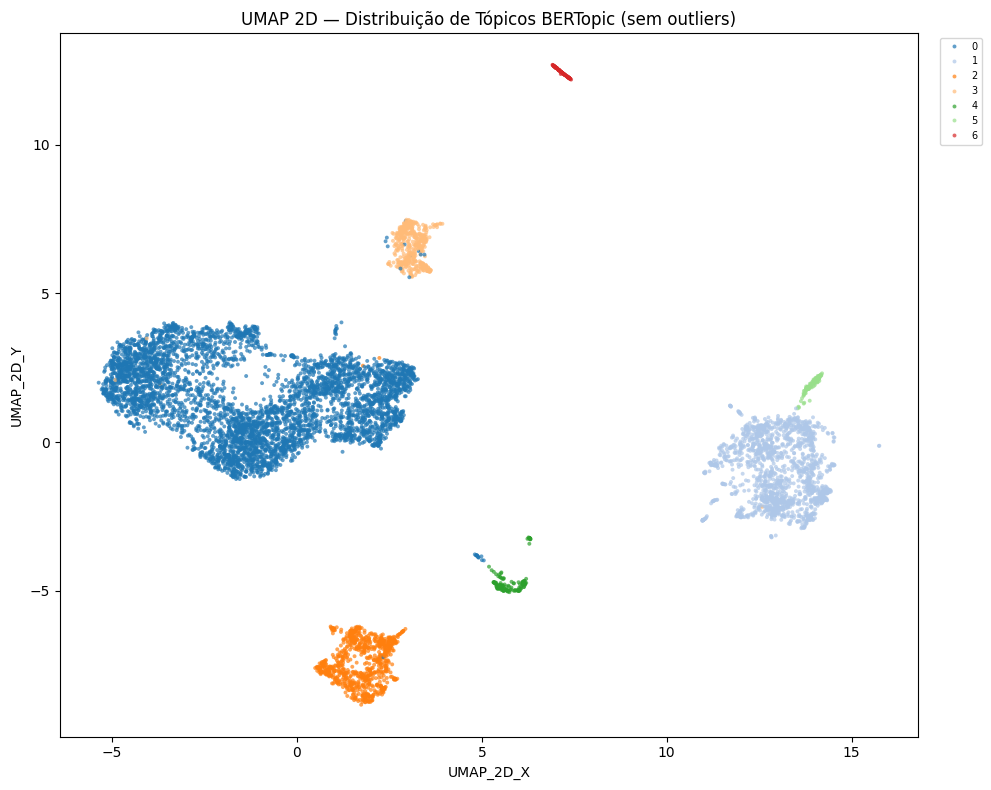


✅ Figura UMAP (por tópico) salva em:
    /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/p2_umap_topics_scatter.png


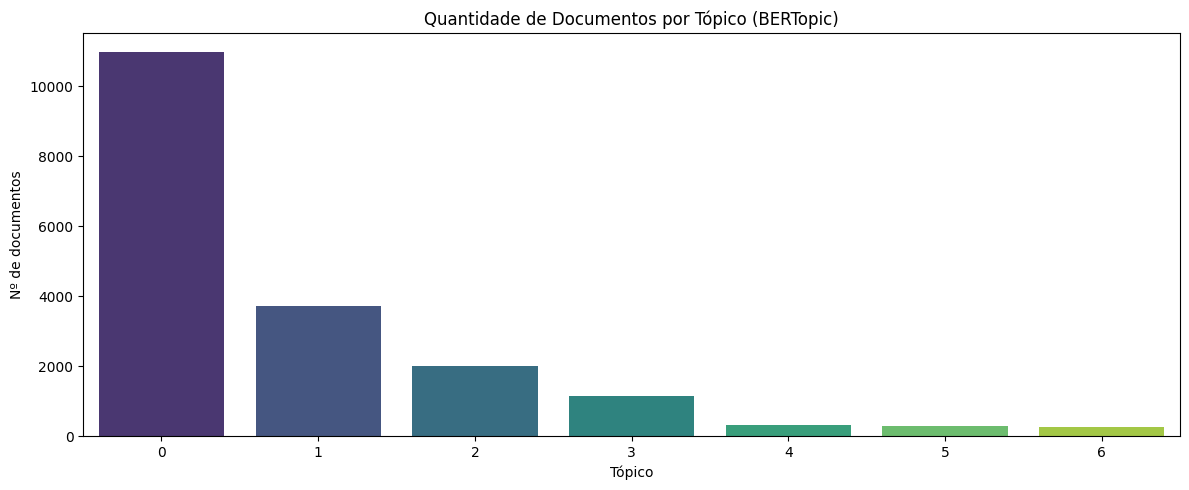


✅ Figura de barras (docs por tópico) salva em:
    /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/p2_bar_docs_por_topico.png


In [ ]:
# ----------------------------------------
# PROJETO 2 — BLOC P2-5 (CORRIGIDO)
# UMAP 2D + visualizações de tópicos
# ----------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap  # já usamos essa forma nos blocos anteriores

# 0. Verificações básicas
needed = ["df_core", "summary_basic", "EMB_PATH", "RESULTS_P2"]
for var in needed:
    if var not in globals():
        raise RuntimeError(f"Variável '{var}' não encontrada. Rode P2-1 e P2-2 antes deste bloco.")

print("Shape df_core:", df_core.shape)

# 1. Garantir que temos os embeddings em disco
EMB_NPY_FILE = os.path.join(EMB_PATH, "UFMG_2021_2025_BERT_CLS_embeddings.npy")
if not os.path.exists(EMB_NPY_FILE):
    raise FileNotFoundError(
        f"Arquivo de embeddings não encontrado:\n  {EMB_NPY_FILE}\n"
        "→ Rode antes o bloco que gera e salva os embeddings BERT."
    )

emb_matrix = np.load(EMB_NPY_FILE)
print("emb_matrix shape:", emb_matrix.shape)

if emb_matrix.shape[0] != len(df_core):
    raise ValueError(
        f"Incompatibilidade: emb_matrix tem {emb_matrix.shape[0]} linhas "
        f"e df_core tem {len(df_core)} linhas.\n"
        "→ Precisamos que a ordem/quantidade de linhas seja a mesma."
    )

# 2. Calcular UMAP 2D para TODO o df_core (se ainda não existir)
if "UMAP_2D_X" not in df_core.columns or "UMAP_2D_Y" not in df_core.columns:
    print("\n[UMAP] Calculando projeção 2D para TODOS os documentos...")
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=42
    )
    umap_emb = reducer.fit_transform(emb_matrix)  # shape [N, 2]

    df_core["UMAP_2D_X"] = umap_emb[:, 0]
    df_core["UMAP_2D_Y"] = umap_emb[:, 1]

    print("[UMAP] Projeção 2D salva em df_core['UMAP_2D_X'], ['UMAP_2D_Y'].")
else:
    print("\n[UMAP] Coordenadas 2D já existem em df_core. Reutilizando.")

# 3. Atualizar df_topics_core com base em df_core (herdando UMAP)
df_topics_core = df_core[df_core["Topic_BERTopic"] != -1].copy()
print("Shape df_topics_core (sem tópico -1):", df_topics_core.shape)

# 4. Scatterplot UMAP colorido por tópico (amostra para não poluir)
N_SAMPLE = 8000
if len(df_topics_core) > N_SAMPLE:
    df_plot = df_topics_core.sample(N_SAMPLE, random_state=42)
else:
    df_plot = df_topics_core.copy()

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x="UMAP_2D_X",
    y="UMAP_2D_Y",
    hue="Topic_BERTopic",
    palette="tab20",
    s=8,
    alpha=0.7,
    linewidth=0
)
plt.title("UMAP 2D — Distribuição de Tópicos BERTopic (sem outliers)")
plt.xlabel("UMAP_2D_X")
plt.ylabel("UMAP_2D_Y")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7)
plt.tight_layout()

UMAP_SCATTER_FILE = os.path.join(RESULTS_P2, "p2_umap_topics_scatter.png")
plt.savefig(UMAP_SCATTER_FILE, dpi=300)
plt.show()

print("\n✅ Figura UMAP (por tópico) salva em:")
print("   ", UMAP_SCATTER_FILE)

# 5. Barplot: quantidade de documentos por tópico
plt.figure(figsize=(12, 5))
sns.barplot(
    data=summary_basic.sort_values("Count", ascending=False),
    x="Topic_BERTopic",
    y="Count",
    palette="viridis"
)
plt.title("Quantidade de Documentos por Tópico (BERTopic)")
plt.xlabel("Tópico")
plt.ylabel("Nº de documentos")
plt.tight_layout()

BAR_FILE = os.path.join(RESULTS_P2, "p2_bar_docs_por_topico.png")
plt.savefig(BAR_FILE, dpi=300)
plt.show()

print("\n✅ Figura de barras (docs por tópico) salva em:")
print("   ", BAR_FILE)


# Melhoria - Projeto 2 (A partir daqui)

In [ ]:
# ----------------------------------------
# P2-A: Setup comum do Projeto 2.0
# ----------------------------------------
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from google.colab import drive

# 1. Montar Drive (sem travar se já estiver montado)
DRIVE_MOUNT_PATH = "/content/drive"
try:
    drive.mount(DRIVE_MOUNT_PATH, force_remount=False)
except Exception as e:
    print(f"[AVISO] Problema ao montar o Drive (pode já estar montado): {e}")

PROJECT_FOLDER = "UFMG_DeepLearning_Lab"
DRIVE_BASE = os.path.join(DRIVE_MOUNT_PATH, "MyDrive", PROJECT_FOLDER)
EMB_PATH = os.path.join(DRIVE_BASE, "data", "embeddings")
RESULTS_PATH = os.path.join(DRIVE_BASE, "results", "projeto2")
MODELS_PATH = os.path.join(DRIVE_BASE, "models", "projeto2")

os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print(f"📁 DRIVE_BASE:      {DRIVE_BASE}")
print(f"📁 EMB_PATH:        {EMB_PATH}")
print(f"📁 RESULTS_PATH:    {RESULTS_PATH}")
print(f"📁 MODELS_PATH:     {MODELS_PATH}")

# 2. Carregar embeddings e metadados, caso ainda não estejam em memória
EMB_NPY_FILE = os.path.join(EMB_PATH, "UFMG_2021_2025_BERT_CLS_embeddings.npy")
META_PARQUET_FILE = os.path.join(EMB_PATH, "UFMG_2021_2025_core_metadata.parquet")

if "emb_matrix" not in globals():
    emb_matrix = np.load(EMB_NPY_FILE)
if "df_core" not in globals():
    df_core = pd.read_parquet(META_PARQUET_FILE)

print(f"✅ emb_matrix shape: {emb_matrix.shape}")
print(f"✅ df_core shape:    {df_core.shape}")

# 3. Garantir TEXT_BERTOPIC
for col in ["Title", "Description", "Subject", "Keywords", "Type", "Year"]:
    if col not in df_core.columns:
        df_core[col] = ""
    df_core[col] = df_core[col].fillna("").astype(str)

import re
def clean_text_basic(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

if "TEXT_BERTOPIC" not in df_core.columns:
    df_core["TEXT_BERTOPIC"] = (
        df_core["Keywords"] + " " +
        df_core["Keywords"] + " " +
        df_core["Keywords"] + " " +   # reforço
        df_core["Subject"] + " " +
        df_core["Title"] + " " +
        df_core["Description"]
    ).apply(clean_text_basic)

texts = df_core["TEXT_BERTOPIC"].tolist()

print("✅ TEXT_BERTOPIC pronto.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 DRIVE_BASE:      /content/drive/MyDrive/UFMG_DeepLearning_Lab
📁 EMB_PATH:        /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/embeddings
📁 RESULTS_PATH:    /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2
📁 MODELS_PATH:     /content/drive/MyDrive/UFMG_DeepLearning_Lab/models/projeto2
✅ emb_matrix shape: (18743, 768)
✅ df_core shape:    (18743, 16)
✅ TEXT_BERTOPIC pronto.


# Lab - Artigo da Disciplina

In [ ]:
# ----------------------------------------
# P2-C: Aplicar modelo BERTopic escolhido e gerar tabelas analíticas
# ----------------------------------------
!pip install bertopic --quiet

import os
import numpy as np
import pandas as pd
from bertopic import BERTopic
from google.colab import drive

# 0. Montar Drive e definir caminhos
DRIVE_MOUNT_PATH = "/content/drive"
drive.mount(DRIVE_MOUNT_PATH, force_remount=False)

PROJECT_FOLDER = "UFMG_DeepLearning_Lab"
DRIVE_BASE = os.path.join(DRIVE_MOUNT_PATH, "MyDrive", PROJECT_FOLDER)

EMB_PATH     = os.path.join(DRIVE_BASE, "data", "embeddings")
RESULTS_PATH = os.path.join(DRIVE_BASE, "results", "projeto2")
MODELS_PATH  = os.path.join(DRIVE_BASE, "models", "projeto2")

os.makedirs(RESULTS_PATH, exist_ok=True)

CORE_META_FILE = os.path.join(EMB_PATH, "UFMG_2021_2025_core_metadata.parquet")

print(f"📄 Metadados centrais: {CORE_META_FILE}")
print(f"📁 Pasta de modelos P2: {MODELS_PATH}")
print(f"📁 Pasta de resultados P2: {RESULTS_PATH}")

# 1. Carregar df_core com metadados (Title, Type, Year, Subject, Keywords, Description)
df_core = pd.read_parquet(CORE_META_FILE)
print(f"\n✅ df_core carregado: {df_core.shape[0]} registros, colunas: {list(df_core.columns)}")

# Garante colunas essenciais
for col in ["Title", "Description", "Subject", "Keywords", "Type", "Year"]:
    if col not in df_core.columns:
        df_core[col] = ""
    df_core[col] = df_core[col].fillna("")

# Reconstruir TEXT_BERTOPIC se ainda não existir
import re

def clean_text_basic(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

if "TEXT_BERTOPIC" not in df_core.columns:
    df_core["TEXT_BERTOPIC"] = (
        df_core["Keywords"] + " " +
        df_core["Keywords"] + " " +
        df_core["Keywords"] + " " +   # reforço em Keywords
        df_core["Subject"] + " " +
        df_core["Title"] + " " +
        df_core["Description"]
    ).apply(clean_text_basic)

texts = df_core["TEXT_BERTOPIC"].tolist()
print(f"Total de documentos para topic modeling: {len(texts)}")

# 2. Escolher qual modelo BERTopic usar (conforme P2-B)
#    → troque aqui se quiser usar 'BERTimbau' ou 'MultiMiniLM'
BEST_LABEL = "MiniLM_v2"  # opções: "MiniLM_v2", "BERTimbau", "MultiMiniLM"

MODEL_PATH = os.path.join(MODELS_PATH, f"bertopic_{BEST_LABEL}", "model.bertopic")
print(f"\n🔎 Carregando modelo BERTopic escolhido ({BEST_LABEL}) em:\n  {MODEL_PATH}")

topic_model = BERTopic.load(MODEL_PATH)
print("✅ Modelo carregado com sucesso.")

# 3. Aplicar o modelo aos textos (sem re-treinar)
print("\n[BERTopic] Atribuindo tópicos a todos os documentos (transform)...")
topics, probs = topic_model.transform(texts)
df_core["Topic_BERTopic"] = topics

# 4. Filtrar tópicos válidos (>= 0)
df_topics_core = df_core[df_core["Topic_BERTopic"] >= 0].copy()
print(f"\n✅ df_topics_core (apenas tópicos válidos) -> {df_topics_core.shape}")

# 5. Tabela-resumo por tópico (contagem, intervalo de anos, tipo modal)
topic_basic = (
    df_topics_core
    .groupby("Topic_BERTopic")
    .agg(
        Count    = ("Title", "size"),
        Year_min = ("Year",  "min"),
        Year_max = ("Year",  "max"),
        Type_mode = ("Type", lambda x: x.mode().iloc[0] if not x.mode().empty else "")
    )
    .reset_index()
)

print("\n===== RESUMO BÁSICO POR TÓPICO (top 15) =====")
print(topic_basic.head(15))

# 6. Recuperar info semântica do modelo (termos e docs representativos)
topic_info = topic_model.get_topic_info().rename(columns={"Topic": "Topic_BERTopic"})

topic_extended = topic_basic.merge(
    topic_info,
    on="Topic_BERTopic",
    how="left",
    suffixes=("", "_info")
)

# 7. Distribuição de tipos por tópico
topic_type_dist = (
    df_topics_core
    .groupby(["Topic_BERTopic", "Type"])
    .size()
    .reset_index(name="Count")
)

topic_type_dist["Total"] = topic_type_dist.groupby("Topic_BERTopic")["Count"].transform("sum")
topic_type_dist["Pct"]   = 100 * topic_type_dist["Count"] / topic_type_dist["Total"]

print("\n===== DISTRIBUIÇÃO DE TIPOS (%) POR TÓPICO (primeiras linhas) =====")
print(topic_type_dist.head(20))

# 8. Distribuição de anos por tópico
topic_year_dist = (
    df_topics_core
    .groupby(["Topic_BERTopic", "Year"])
    .size()
    .reset_index(name="Count")
)

print("\n===== DISTRIBUIÇÃO DE ANOS POR TÓPICO (primeiras linhas) =====")
print(topic_year_dist.head(20))

# 9. Salvar tudo no Drive
TOPIC_BASIC_FILE    = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_topic_basic.csv")
TOPIC_EXTENDED_FILE = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_topic_extended.csv")
TOPIC_TYPE_FILE     = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_topic_type_dist.csv")
TOPIC_YEAR_FILE     = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_topic_year_dist.csv")
TOPIC_CORE_PARQ     = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_df_topics_core.parquet")

topic_basic.to_csv(TOPIC_BASIC_FILE, index=False)
topic_extended.to_csv(TOPIC_EXTENDED_FILE, index=False)
topic_type_dist.to_csv(TOPIC_TYPE_FILE, index=False)
topic_year_dist.to_csv(TOPIC_YEAR_FILE, index=False)
df_topics_core.to_parquet(TOPIC_CORE_PARQ, index=False)

print("\n✅ Arquivos salvos:")
print("  •", TOPIC_BASIC_FILE)
print("  •", TOPIC_EXTENDED_FILE)
print("  •", TOPIC_TYPE_FILE)
print("  •", TOPIC_YEAR_FILE)
print("  •", TOPIC_CORE_PARQ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 Metadados centrais: /content/drive/MyDrive/UFMG_DeepLearning_Lab/data/embeddings/UFMG_2021_2025_core_metadata.parquet
📁 Pasta de modelos P2: /content/drive/MyDrive/UFMG_DeepLearning_Lab/models/projeto2
📁 Pasta de resultados P2: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2

✅ df_core carregado: 18743 registros, colunas: ['Title', 'Authors', 'Advisors', 'Referees', 'Type', 'Year', 'Subject', 'Keywords', 'Description', 'Language', 'TEXTO_UNIFICADO']
Total de documentos para topic modeling: 18743

🔎 Carregando modelo BERTopic escolhido (MiniLM_v2) em:
  /content/drive/MyDrive/UFMG_DeepLearning_Lab/models/projeto2/bertopic_MiniLM_v2/model.bertopic
✅ Modelo carregado com sucesso.

[BERTopic] Atribuindo tópicos a todos os documentos (transform)...


Batches:   0%|          | 0/586 [00:00<?, ?it/s]

2025-12-06 05:11:41,112 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-06 05:11:41,167 - BERTopic - Dimensionality - Completed ✓
2025-12-06 05:11:41,168 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-06 05:11:42,345 - BERTopic - Cluster - Completed ✓



✅ df_topics_core (apenas tópicos válidos) -> (12037, 13)

===== RESUMO BÁSICO POR TÓPICO (top 15) =====
    Topic_BERTopic  Count  Year_min  Year_max                     Type_mode
0                0   1586      2021      2025           Artigo de periódico
1                1   1009      2021      2025           Artigo de periódico
2                2   1008      2021      2025  Monografia de especialização
3                3    591      2021      2025           Artigo de periódico
4                4    568      2021      2025       Dissertação de mestrado
5                5    518      2021      2025       Dissertação de mestrado
6                6    513      2021      2025           Artigo de periódico
7                7    399      2021      2025           Artigo de periódico
8                8    362      2021      2025       Dissertação de mestrado
9                9    352      2021      2025       Dissertação de mestrado
10              10    336      2021      2025           Art

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando BEST_LABEL = MiniLM_v2
📄 CORE_PARQ_FILE: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_df_topics_core.parquet
📄 UMAP_PARQ_FILE: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_df_topics_umap.parquet

✅ df_core_topics: (12037, 13)
✅ df_umap:        (12037, 15)

Registros válidos em df_core_valid: 12037
Registros válidos em df_umap_valid: 12037

Top 5 tópicos por tamanho: [0, 1, 2, 3, 4]


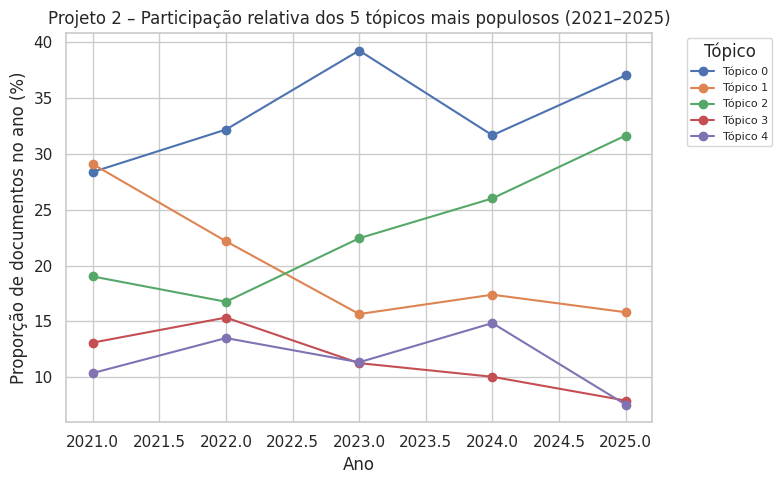

📊 Figura de trajetória salva em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_trajetoria_top5_topics.png


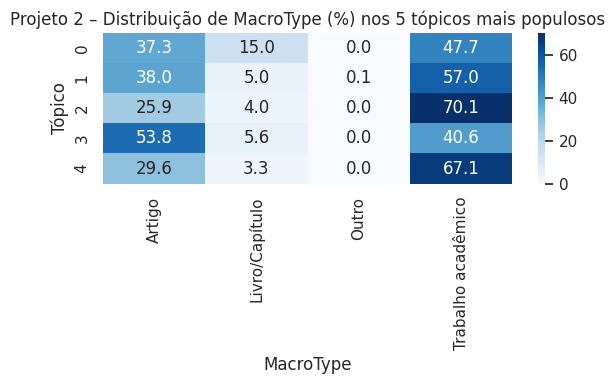

📊 Heatmap tópico × MacroType salvo em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_heatmap_macrotipo_top5_topics.png


<Figure size 800x400 with 0 Axes>

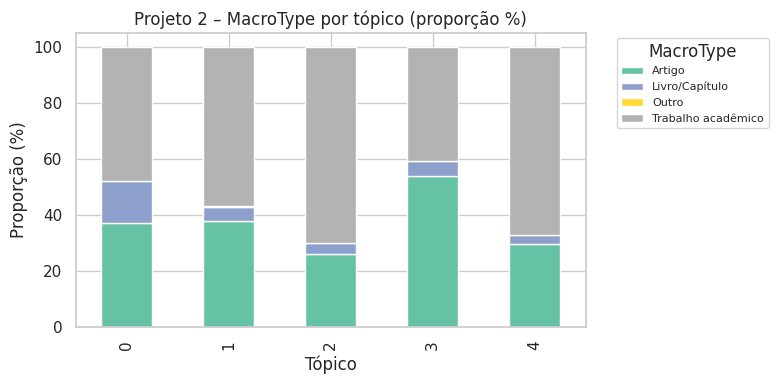

📊 Barras empilhadas salvas em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_barras_empilhadas_macrotipo_top5_topics.png


In [ ]:
# ----------------------------------------
# P2-E: Gráficos prontos para artigo (trajetórias e heatmaps)
# ----------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 0. Montar Drive e configurar caminhos
DRIVE_MOUNT_PATH = "/content/drive"
drive.mount(DRIVE_MOUNT_PATH, force_remount=False)

PROJECT_FOLDER = "UFMG_DeepLearning_Lab"
DRIVE_BASE = os.path.join(DRIVE_MOUNT_PATH, "MyDrive", PROJECT_FOLDER)

RESULTS_PATH = os.path.join(DRIVE_BASE, "results", "projeto2")
os.makedirs(RESULTS_PATH, exist_ok=True)

# Se BEST_LABEL não estiver definido, usa o padrão
try:
    BEST_LABEL
except NameError:
    BEST_LABEL = "MiniLM_v2"

print(f"Usando BEST_LABEL = {BEST_LABEL}")

# Arquivos gerados em P2-C e P2-D
CORE_PARQ_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_df_topics_core.parquet"
)
UMAP_PARQ_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_df_topics_umap.parquet"
)

print("📄 CORE_PARQ_FILE:", CORE_PARQ_FILE)
print("📄 UMAP_PARQ_FILE:", UMAP_PARQ_FILE)

# 1. Carregar dataframes
df_core_topics = pd.read_parquet(CORE_PARQ_FILE)
df_umap = pd.read_parquet(UMAP_PARQ_FILE)

print(f"\n✅ df_core_topics: {df_core_topics.shape}")
print(f"✅ df_umap:        {df_umap.shape}")

# 2. Função para mapear MacroType (igual P2-D)
def map_macro_type(t):
    t = str(t)
    if "Artigo de periódico" in t or "Artigo de evento" in t:
        return "Artigo"
    if "Livro" in t or "Capítulo de livro" in t:
        return "Livro/Capítulo"
    if (
        "Dissertação" in t
        or "Tese" in t
        or "Monografia" in t
        or "Trabalho de conclusão de curso" in t
    ):
        return "Trabalho acadêmico"
    return "Outro"

df_core_topics["MacroType"] = df_core_topics["Type"].apply(map_macro_type)
df_umap["MacroType"] = df_umap["Type"].apply(map_macro_type)

# Garantir que Year é numérico
df_core_topics["Year"] = pd.to_numeric(df_core_topics["Year"], errors="coerce").astype("Int64")
df_umap["Year"] = pd.to_numeric(df_umap["Year"], errors="coerce").astype("Int64")

# Filtrar apenas tópicos válidos
df_core_valid = df_core_topics[df_core_topics["Topic_BERTopic"] >= 0].copy()
df_umap_valid = df_umap[df_umap["Topic_BERTopic"] >= 0].copy()

print(f"\nRegistros válidos em df_core_valid: {df_core_valid.shape[0]}")
print(f"Registros válidos em df_umap_valid: {df_umap_valid.shape[0]}")

# ----------------------------------------
# 3. Gráfico 1 – Trajetória ano × tópico (top K tópicos)
# ----------------------------------------
K = 5  # número de tópicos mais populosos
sns.set(style="whitegrid")

# contagem de documentos por tópico
top_topics = (
    df_core_valid["Topic_BERTopic"]
    .value_counts()
    .head(K)
    .index
    .tolist()
)
print(f"\nTop {K} tópicos por tamanho:", top_topics)

df_traj = (
    df_core_valid[df_core_valid["Topic_BERTopic"].isin(top_topics)]
    .groupby(["Year", "Topic_BERTopic"])
    .size()
    .reset_index(name="Count")
)

# normalizar por ano para obter proporção relativa
df_traj["TotalYear"] = df_traj.groupby("Year")["Count"].transform("sum")
df_traj["Pct"] = 100.0 * df_traj["Count"] / df_traj["TotalYear"]

plt.figure(figsize=(8, 5))
for topic_id in top_topics:
    sub = df_traj[df_traj["Topic_BERTopic"] == topic_id].sort_values("Year")
    plt.plot(sub["Year"], sub["Pct"], marker="o", label=f"Tópico {topic_id}")

plt.title(f"Projeto 2 – Participação relativa dos {K} tópicos mais populosos (2021–2025)")
plt.xlabel("Ano")
plt.ylabel("Proporção de documentos no ano (%)")
plt.legend(title="Tópico", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()

FIG_TRAJ_FILE = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_trajetoria_top{K}_topics.png")
plt.savefig(FIG_TRAJ_FILE, dpi=300)
plt.show()

print("📊 Figura de trajetória salva em:", FIG_TRAJ_FILE)

# ----------------------------------------
# 4. Gráfico 2 – Heatmap tópico × MacroType
# ----------------------------------------
df_heat = (
    df_core_valid
    .groupby(["Topic_BERTopic", "MacroType"])
    .size()
    .reset_index(name="Count")
)

# normalizar por tópico (linha)
df_heat["TotalTopic"] = df_heat.groupby("Topic_BERTopic")["Count"].transform("sum")
df_heat["Pct"] = 100.0 * df_heat["Count"] / df_heat["TotalTopic"]

# manter apenas os top tópicos (para ficar legível)
df_heat_top = df_heat[df_heat["Topic_BERTopic"].isin(top_topics)].copy()

pivot_heat = df_heat_top.pivot_table(
    index="Topic_BERTopic",
    columns="MacroType",
    values="Pct",
    fill_value=0.0
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_heat,
    annot=True,
    fmt=".1f",
    cmap="Blues"
)
plt.title(f"Projeto 2 – Distribuição de MacroType (%) nos {K} tópicos mais populosos")
plt.xlabel("MacroType")
plt.ylabel("Tópico")
plt.tight_layout()

FIG_HEAT_FILE = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_heatmap_macrotipo_top{K}_topics.png")
plt.savefig(FIG_HEAT_FILE, dpi=300)
plt.show()

print("📊 Heatmap tópico × MacroType salvo em:", FIG_HEAT_FILE)

# ----------------------------------------
# 5. (Opcional) Gráfico 3 – barras empilhadas de MacroType por tópico
# ----------------------------------------
plt.figure(figsize=(8, 4))
pivot_heat.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 4),
    colormap="Set2"
)
plt.title(f"Projeto 2 – MacroType por tópico (proporção %)")
plt.xlabel("Tópico")
plt.ylabel("Proporção (%)")
plt.legend(title="MacroType", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()

FIG_BAR_FILE = os.path.join(RESULTS_PATH, f"projeto2_{BEST_LABEL}_barras_empilhadas_macrotipo_top{K}_topics.png")
plt.savefig(FIG_BAR_FILE, dpi=300)
plt.show()

print("📊 Barras empilhadas salvas em:", FIG_BAR_FILE)


In [ ]:
# ----------------------------------------
# P2-F: Tabelas sintéticas para o artigo (Projeto 2)
# - Resumo por tópico
# - Distribuição de tipos por tópico
# - Distribuição de anos por tópico
# - Tópicos + termos representativos
# ----------------------------------------
import os
import numpy as np
import pandas as pd
from google.colab import drive

# 0. Montar Drive e configurar caminhos
DRIVE_MOUNT_PATH = "/content/drive"
drive.mount(DRIVE_MOUNT_PATH, force_remount=False)

PROJECT_FOLDER = "UFMG_DeepLearning_Lab"
DRIVE_BASE = os.path.join(DRIVE_MOUNT_PATH, "MyDrive", PROJECT_FOLDER)

RESULTS_PATH = os.path.join(DRIVE_BASE, "results", "projeto2")
os.makedirs(RESULTS_PATH, exist_ok=True)

# Se BEST_LABEL não estiver definido, usar padrão
try:
    BEST_LABEL
except NameError:
    BEST_LABEL = "MiniLM_v2"

CORE_PARQ_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_df_topics_core.parquet"
)
TOPIC_INFO_FILE = os.path.join(
    RESULTS_PATH, f"bertopic_{BEST_LABEL}_topic_info.csv"
)

print("📄 CORE_PARQ_FILE:  ", CORE_PARQ_FILE)
print("📄 TOPIC_INFO_FILE: ", TOPIC_INFO_FILE)

# 1. Carregar dataframes principais
df_core = pd.read_parquet(CORE_PARQ_FILE)
topic_info = pd.read_csv(TOPIC_INFO_FILE)

print(f"\n✅ df_core:      {df_core.shape}")
print(f"✅ topic_info:   {topic_info.shape}")

print("\nColunas df_core:", df_core.columns.tolist())
print("Colunas topic_info:", topic_info.columns.tolist())

# 2. Garantir Topic_BERTopic
if "Topic_BERTopic" not in df_core.columns:
    if "Topic" in df_core.columns:
        df_core["Topic_BERTopic"] = df_core["Topic"]
        print("⚠️ 'Topic_BERTopic' não existia em df_core; usei coluna 'Topic'.")
    else:
        raise ValueError(
            "df_core não contém 'Topic_BERTopic' nem 'Topic'. "
            "Verifique o bloco de tópicos (P2-B/C)."
        )

if "Topic_BERTopic" not in topic_info.columns:
    if "Topic" in topic_info.columns:
        topic_info = topic_info.rename(columns={"Topic": "Topic_BERTopic"})
    else:
        raise ValueError(
            "topic_info não contém 'Topic_BERTopic' nem 'Topic'. "
            "Verifique salvamento em P2-B."
        )

# 3. Criar rótulo curto de tópico
def shorten_name(name, max_terms=3):
    if not isinstance(name, str):
        return ""
    parts = name.split("_", 1)
    if len(parts) == 2:
        label_part = parts[1]
    else:
        label_part = parts[0]
    tokens = [t for t in label_part.split("_") if t.strip() != ""]
    return "/".join(tokens[:max_terms])

topic_info["TopicLabel"] = topic_info["Name"].apply(shorten_name)

# 4. Macrotipo: Artigo / Livro/Capítulo / Trabalho Acadêmico
def map_macro_type(t):
    t = str(t)
    if "Artigo" in t:
        return "Artigo"
    if "Capítulo" in t or "Livro" in t:
        return "Livro/Capítulo"
    return "Trabalho Acadêmico"

df_core["MacroType"] = df_core["Type"].apply(map_macro_type)

# 5. Year numérico (int) e filtro de tópicos válidos (>=0)
df_core["Year"] = pd.to_numeric(df_core["Year"], errors="coerce").astype("Int64")
df_valid = df_core[
    (df_core["Topic_BERTopic"] >= 0) & (~df_core["Year"].isna())
].copy()
df_valid["Year"] = df_valid["Year"].astype(int)

print(f"\nRegistros válidos (tópico >= 0 e ano definido): {df_valid.shape[0]}")

# ----------------------------------------
# 6. Tabela 1 – Resumo por tópico
# ----------------------------------------
# Count total por tópico
topic_counts = (
    df_valid.groupby("Topic_BERTopic")
    .size()
    .reset_index(name="Count")
)

# Ano mínimo e máximo
topic_years = (
    df_valid.groupby("Topic_BERTopic")["Year"]
    .agg(["min", "max"])
    .reset_index()
    .rename(columns={"min": "Year_min", "max": "Year_max"})
)

# Tipo mais frequente (Type_mode)
topic_type_mode = (
    df_valid.groupby("Topic_BERTopic")["Type"]
    .agg(lambda s: s.value_counts().index[0])
    .reset_index()
    .rename(columns={"Type": "Type_mode"})
)

# Macrotipo mais frequente
topic_macro_mode = (
    df_valid.groupby("Topic_BERTopic")["MacroType"]
    .agg(lambda s: s.value_counts().index[0])
    .reset_index()
    .rename(columns={"MacroType": "MacroType_mode"})
)

# Juntar tudo com topic_info (para pegar Name + TopicLabel)
topic_summary = (
    topic_counts
    .merge(topic_years, on="Topic_BERTopic", how="left")
    .merge(topic_type_mode, on="Topic_BERTopic", how="left")
    .merge(topic_macro_mode, on="Topic_BERTopic", how="left")
    .merge(
        topic_info[["Topic_BERTopic", "Name", "TopicLabel"]],
        on="Topic_BERTopic",
        how="left"
    )
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)

print("\n===== TABELA 1 – RESUMO POR TÓPICO (head) =====")
print(topic_summary.head(10))

TAB1_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_tabela_resumo_topicos.csv"
)
topic_summary.to_csv(TAB1_FILE, index=False)
print("\n💾 Tabela 1 salva em:", TAB1_FILE)

# ----------------------------------------
# 7. Tabela 2 – Distribuição de tipos por tópico
#    (contagem + % dentro do tópico)
# ----------------------------------------
topic_type = (
    df_valid.groupby(["Topic_BERTopic", "Type"])
    .size()
    .reset_index(name="Count")
)

topic_type["TotalTopic"] = topic_type.groupby("Topic_BERTopic")["Count"].transform("sum")
topic_type["Pct_in_topic"] = 100.0 * topic_type["Count"] / topic_type["TotalTopic"]

# Acrescentar rótulo curto
topic_type = topic_type.merge(
    topic_info[["Topic_BERTopic", "TopicLabel"]],
    on="Topic_BERTopic",
    how="left"
)

print("\n===== TABELA 2 – TIPOS POR TÓPICO (head) =====")
print(topic_type.head(15))

TAB2_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_tabela_tipos_por_topico.csv"
)
topic_type.to_csv(TAB2_FILE, index=False)
print("\n💾 Tabela 2 salva em:", TAB2_FILE)

# ----------------------------------------
# 8. Tabela 3 – Distribuição de anos por tópico
#    (contagem + % dentro do tópico)
# ----------------------------------------
topic_year = (
    df_valid.groupby(["Topic_BERTopic", "Year"])
    .size()
    .reset_index(name="Count")
)

topic_year["TotalTopic"] = topic_year.groupby("Topic_BERTopic")["Count"].transform("sum")
topic_year["Pct_in_topic"] = 100.0 * topic_year["Count"] / topic_year["TotalTopic"]

topic_year = topic_year.merge(
    topic_info[["Topic_BERTopic", "TopicLabel"]],
    on="Topic_BERTopic",
    how="left"
)

print("\n===== TABELA 3 – ANOS POR TÓPICO (head) =====")
print(topic_year.head(15))

TAB3_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_tabela_anos_por_topico.csv"
)
topic_year.to_csv(TAB3_FILE, index=False)
print("\n💾 Tabela 3 salva em:", TAB3_FILE)

# ----------------------------------------
# 9. Tabela 4 – Tópicos + termos representativos (para leitura qualitativa)
# ----------------------------------------
topic_terms = topic_info[[
    "Topic_BERTopic", "Name", "TopicLabel", "Representation"
]].copy()

print("\n===== TABELA 4 – TÓPICOS E TERMOS (head) =====")
print(topic_terms.head(10))

TAB4_FILE = os.path.join(
    RESULTS_PATH, f"projeto2_{BEST_LABEL}_tabela_termos_topicos.csv"
)
topic_terms.to_csv(TAB4_FILE, index=False)
print("\n💾 Tabela 4 salva em:", TAB4_FILE)

print("\n✅ P2-F concluído. Tabelas sintéticas geradas e salvas para uso no artigo.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 CORE_PARQ_FILE:   /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_df_topics_core.parquet
📄 TOPIC_INFO_FILE:  /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/bertopic_MiniLM_v2_topic_info.csv

✅ df_core:      (12037, 13)
✅ topic_info:   (49, 5)

Colunas df_core: ['Title', 'Authors', 'Advisors', 'Referees', 'Type', 'Year', 'Subject', 'Keywords', 'Description', 'Language', 'TEXTO_UNIFICADO', 'TEXT_BERTOPIC', 'Topic_BERTopic']
Colunas topic_info: ['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs']

Registros válidos (tópico >= 0 e ano definido): 12037

===== TABELA 1 – RESUMO POR TÓPICO (head) =====
   Topic_BERTopic  Count  Year_min  Year_max                     Type_mode  \
0               0   1586      2021      2025           Artigo de periódico   
1               1   1009      2021      2025   

In [ ]:
# -------------------------------------------------
# P2-EVAL-4: TABELA EPISTÊMICA DOS TÓPICOS (VERSÃO FINAL BLINDADA)
# -------------------------------------------------
import os
import pandas as pd

from google.colab import drive
drive.mount("/content/drive", force_remount=False)

# --- Caminhos ---
BASE_PATH = "/content/drive/MyDrive/UFMG_DeepLearning_Lab"
RESULTS_P2 = os.path.join(BASE_PATH, "results", "projeto2")

CORE_PARQ_FILE = os.path.join(
    RESULTS_P2,
    "projeto2_MiniLM_v2_df_topics_core.parquet"
)

TOPIC_INFO_FILE = os.path.join(
    RESULTS_P2,
    "bertopic_MiniLM_v2_topic_info.csv"
)

print("📄 CORE_PARQ_FILE:", CORE_PARQ_FILE)
print("📄 TOPIC_INFO_FILE:", TOPIC_INFO_FILE)

# --- Carregar dados ---
df_core = pd.read_parquet(CORE_PARQ_FILE)
topic_info = pd.read_csv(TOPIC_INFO_FILE)

print("\n✅ df_core shape:", df_core.shape)
print("✅ topic_info shape:", topic_info.shape)

print("\nColunas df_core:", df_core.columns.tolist())
print("Colunas topic_info:", topic_info.columns.tolist())

# --- Garantias ---
if "Topic_BERTopic" not in df_core.columns:
    raise ValueError("❌ Coluna 'Topic_BERTopic' não existe em df_core.")

if "Year" not in df_core.columns:
    raise ValueError("❌ Coluna 'Year' não existe em df_core.")

if "Type" not in df_core.columns:
    raise ValueError("❌ Coluna 'Type' não existe em df_core.")

# Corrigir ano (remover .0 se existir)
df_core["Year"] = pd.to_numeric(df_core["Year"], errors="coerce").astype("Int64")

# -------------------------------------------------
# 1) Síntese quantitativa por tópico
# -------------------------------------------------
grouped = df_core.groupby("Topic_BERTopic").agg(
    n_docs=("Topic_BERTopic", "size"),
    Year_min=("Year", "min"),
    Year_max=("Year", "max")
).reset_index()

# -------------------------------------------------
# 2) Tipo modal por tópico
# -------------------------------------------------
type_mode = (
    df_core.groupby("Topic_BERTopic")["Type"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
    .rename(columns={"Type": "Type_mode"})
)

topics_summary = grouped.merge(type_mode, on="Topic_BERTopic", how="left")

# -------------------------------------------------
# 3) Info do BERTopic (renomeando Count)
# -------------------------------------------------
if "Topic" not in topic_info.columns:
    raise ValueError("❌ A coluna 'Topic' não existe em topic_info.")

topic_info_ren = topic_info.rename(
    columns={
        "Topic": "Topic_BERTopic",
        "Count": "Count_topicinfo"
    }
)

df_topics_epistemic = topics_summary.merge(
    topic_info_ren,
    on="Topic_BERTopic",
    how="left"
)

# -------------------------------------------------
# 4) Exemplos de títulos por tópico
# -------------------------------------------------
examples_per_topic = []
for t, sub in df_core.groupby("Topic_BERTopic"):
    titles = sub["Title"].dropna().astype(str).unique().tolist()
    examples_per_topic.append({
        "Topic_BERTopic": t,
        "Example_Title_1": titles[0][:150] if len(titles) > 0 else "",
        "Example_Title_2": titles[1][:150] if len(titles) > 1 else ""
    })

df_examples = pd.DataFrame(examples_per_topic)

df_topics_epistemic = df_topics_epistemic.merge(
    df_examples,
    on="Topic_BERTopic",
    how="left"
)

# -------------------------------------------------
# 5) Ordenar pelos tópicos mais densos
# -------------------------------------------------
df_topics_epistemic = df_topics_epistemic.sort_values(
    "n_docs",
    ascending=False
)

# -------------------------------------------------
# 6) Salvar resultado
# -------------------------------------------------
EPI_FILE = os.path.join(
    RESULTS_P2,
    "projeto2_eval_topics_epistemic_table.csv"
)

df_topics_epistemic.to_csv(EPI_FILE, index=False)

# -------------------------------------------------
# 7) Exibir TOP 10 interpretável
# -------------------------------------------------
print("\n===== TABELA EPISTÊMICA – TOP 10 TÓPICOS =====")

cols_show = [
    "Topic_BERTopic",
    "n_docs",
    "Year_min",
    "Year_max",
    "Type_mode",
    "Name",
    "Representation",
    "Example_Title_1",
    "Example_Title_2",
    "Count_topicinfo"
]

cols_show = [c for c in cols_show if c in df_topics_epistemic.columns]

print(df_topics_epistemic[cols_show].head(10))

print("\n📁 Tabela epistêmica completa salva em:")
print(EPI_FILE)
print("\n✅ P2-EVAL-4 concluído com sucesso.")


Mounted at /content/drive
📄 CORE_PARQ_FILE: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_df_topics_core.parquet
📄 TOPIC_INFO_FILE: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/bertopic_MiniLM_v2_topic_info.csv

✅ df_core shape: (12037, 13)
✅ topic_info shape: (49, 5)

Colunas df_core: ['Title', 'Authors', 'Advisors', 'Referees', 'Type', 'Year', 'Subject', 'Keywords', 'Description', 'Language', 'TEXTO_UNIFICADO', 'TEXT_BERTOPIC', 'Topic_BERTopic']
Colunas topic_info: ['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs']

===== TABELA EPISTÊMICA – TOP 10 TÓPICOS =====
   Topic_BERTopic  n_docs  Year_min  Year_max                     Type_mode  \
0               0    1586      2021      2025           Artigo de periódico   
1               1    1009      2021      2025           Artigo de periódico   
2               2    1008      2021      2025  Monografia de especialização   
3               3     591      2021      202

In [ ]:
# =========================================================
# P2-EVAL-ALL — AVALIAÇÃO COMPLETA DO PROJETO 2 (FINAL)
# =========================================================

# =========================
# 0) INSTALAÇÃO GARANTIDA
# =========================
!pip install -U bertopic hdbscan sentence-transformers umap-learn scikit-learn --quiet

# =========================
# 1) IMPORTAÇÕES
# =========================
import os
import numpy as np
import pandas as pd
import torch

from bertopic import BERTopic
from sklearn.metrics import (
    classification_report, accuracy_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive

# =========================
# 2) MONTAGEM DO DRIVE
# =========================
drive.mount("/content/drive", force_remount=False)

BASE_PATH = "/content/drive/MyDrive/UFMG_DeepLearning_Lab"
RESULTS_P2 = os.path.join(BASE_PATH, "results", "projeto2")
os.makedirs(RESULTS_P2, exist_ok=True)

CORE_PARQ_FILE  = os.path.join(RESULTS_P2, "projeto2_MiniLM_v2_df_topics_core.parquet")
TOPIC_INFO_FILE = os.path.join(RESULTS_P2, "bertopic_MiniLM_v2_topic_info.csv")

# =========================
# 3) CARGA DOS DADOS
# =========================
df_core = pd.read_parquet(CORE_PARQ_FILE)
topic_info = pd.read_csv(TOPIC_INFO_FILE)

df_core["Year"] = df_core["Year"].astype(int)

print("✅ df_core:", df_core.shape)
print("✅ topic_info:", topic_info.shape)

# ========================================================
# P2-EVAL-1 — COERÊNCIA SEMÂNTICA INTRA-TÓPICO (REAL)
# ========================================================
print("\n===============================")
print("P2-EVAL-1 – Coerência Semântica")
print("===============================")

model_emb = SentenceTransformer("all-MiniLM-L6-v2")
X_emb = model_emb.encode(df_core["TEXT_BERTOPIC"].tolist(), show_progress_bar=True)

df_core["emb_id"] = np.arange(len(df_core))

coherence_rows = []

for topic in sorted(df_core["Topic_BERTopic"].unique()):
    if topic < 0:
        continue

    idx = df_core[df_core["Topic_BERTopic"] == topic]["emb_id"].values
    vecs = X_emb[idx]

    centroid = vecs.mean(axis=0, keepdims=True)
    cos_vals = cosine_similarity(vecs, centroid).flatten()

    coherence_rows.append({
        "Topic_BERTopic": topic,
        "n_docs": len(idx),
        "mean_cosine_centroid": float(cos_vals.mean()),
        "std_cosine_centroid": float(cos_vals.std())
    })

df_coh = pd.DataFrame(coherence_rows)
df_coh.to_csv(os.path.join(RESULTS_P2, "projeto2_eval_coherence_cosine.csv"), index=False)

print("\n✅ Coerência média global:", round(df_coh["mean_cosine_centroid"].mean(), 4))

# ========================================================
# P2-EVAL-2 — ESTABILIDADE REAL (ARI / NMI)
# ========================================================
print("\n===============================")
print("P2-EVAL-2 – Estabilidade (ARI/NMI)")
print("===============================")

texts = df_core["TEXT_BERTOPIC"].tolist()

topic_model_A = BERTopic(min_topic_size=30)
topics_A, _ = topic_model_A.fit_transform(texts)

topic_model_B = BERTopic(min_topic_size=50)
topics_B, _ = topic_model_B.fit_transform(texts)

topics_A = np.array(topics_A)
topics_B = np.array(topics_B)

mask_valid = (topics_A >= 0) & (topics_B >= 0)

labels_A = topics_A[mask_valid]
labels_B = topics_B[mask_valid]

ari = adjusted_rand_score(labels_A, labels_B)
nmi = normalized_mutual_info_score(labels_A, labels_B)

with open(os.path.join(RESULTS_P2, "projeto2_eval_stability_ari_nmi.txt"), "w") as f:
    f.write(f"ARI: {ari}\nNMI: {nmi}\n")

print("✅ ARI:", round(ari, 4))
print("✅ NMI:", round(nmi, 4))

# ========================================================
# P2-EVAL-3 — VALIDAÇÃO SUPERVISIONADA REAL (Type)
# ========================================================
print("\n===============================")
print("P2-EVAL-3 – Validação supervisionada (Type)")
print("===============================")

df_sup = df_core.copy()

# 🔥 CORREÇÃO CRÍTICA: REMOVER CLASSES COM < 2 AMOSTRAS
class_counts = df_sup["Type"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_sup = df_sup[df_sup["Type"].isin(valid_classes)].reset_index(drop=True)

class_labels = sorted(df_sup["Type"].unique())
label2id = {label: idx for idx, label in enumerate(class_labels)}
id2label = {idx: label for label, idx in label2id.items()}

y = df_sup["Type"].map(label2id).values

# FEATURES = One-hot dos tópicos + ano normalizado
topic_oh = pd.get_dummies(df_sup["Topic_BERTopic"], prefix="topic", dtype=float)

year_norm = (df_sup["Year"] - df_sup["Year"].min()) / (
    df_sup["Year"].max() - df_sup["Year"].min()
)

X_meta = pd.concat(
    [topic_oh, year_norm.rename("year_norm")],
    axis=1
).values

# SPLIT CORRIGIDO (agora sempre funciona)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_meta, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

df_report = pd.DataFrame(report).T
df_report.to_csv(os.path.join(RESULTS_P2, "projeto2_eval_supervised_report.csv"))

print("✅ Accuracy supervisionada:", round(acc, 4))

# ========================================================
# P2-EVAL-4 — TABELA EPISTÊMICA FINAL DOS TÓPICOS
# ========================================================
print("\n===============================")
print("P2-EVAL-4 – Tabela Epistêmica")
print("===============================")

grouped = df_core.groupby("Topic_BERTopic").agg(
    n_docs=("Topic_BERTopic", "size"),
    Year_min=("Year", "min"),
    Year_max=("Year", "max"),
    Type_mode=("Type", lambda x: x.mode().iloc[0] if len(x.mode()) else "NA")
).reset_index()

df_topics_epistemic = grouped.merge(
    topic_info.rename(columns={"Topic": "Topic_BERTopic"}),
    on="Topic_BERTopic",
    how="left"
)

df_topics_epistemic = df_topics_epistemic.sort_values("n_docs", ascending=False)

EPI_FILE = os.path.join(RESULTS_P2, "projeto2_eval_topics_epistemic_table.csv")
df_topics_epistemic.to_csv(EPI_FILE, index=False)

print("✅ Tabela epistêmica salva em:", EPI_FILE)

print("\n===============================")
print("✅✅✅ AVALIAÇÃO COMPLETA DO PROJETO 2 FINALIZADA")
print("===============================")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.6 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ df_core: (12037, 13)
✅ topic_info: (49, 5)

P2-EVAL-1 – Coerência Semântica


Batches:   0%|          | 0/377 [00:00<?, ?it/s]


✅ Coerência média global: 0.6703

P2-EVAL-2 – Estabilidade (ARI/NMI)
✅ ARI: 0.9364
✅ NMI: 0.9589

P2-EVAL-3 – Validação supervisionada (Type)
✅ Accuracy supervisionada: 0.407

P2-EVAL-4 – Tabela Epistêmica
✅ Tabela epistêmica salva em: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_eval_topics_epistemic_table.csv

✅✅✅ AVALIAÇÃO COMPLETA DO PROJETO 2 FINALIZADA


# Resumo projeto 2 para entrega


In [ ]:
# =========================================================
# P2-EVAL-ALL v2 — AVALIAÇÃO COMPLETA DO PROJETO 2
# - Coerência semântica intra-tópico (com TOP 10 / BOTTOM 10)
# - Estabilidade de tópicos (ARI / NMI)
# - Validação supervisionada (Type) com duas features:
#     • X_emb_only  (embeddings apenas)
#     • X_combined  (embeddings + meta-features)
# - Tabela epistêmica final (para o artigo)
# =========================================================

# =========================
# 0) INSTALAÇÃO
# =========================
!pip install -U bertopic hdbscan sentence-transformers umap-learn scikit-learn --quiet

# =========================
# 1) IMPORTAÇÕES
# =========================
import os
import numpy as np
import pandas as pd
import torch

from bertopic import BERTopic
from sklearn.metrics import (
    classification_report, accuracy_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive

# =========================
# 2) MONTAR DRIVE
# =========================
drive.mount("/content/drive", force_remount=False)

BASE_PATH = "/content/drive/MyDrive/UFMG_DeepLearning_Lab"
RESULTS_P2 = os.path.join(BASE_PATH, "results", "projeto2")
os.makedirs(RESULTS_P2, exist_ok=True)

CORE_PARQ_FILE  = os.path.join(RESULTS_P2, "projeto2_MiniLM_v2_df_topics_core.parquet")
TOPIC_INFO_FILE = os.path.join(RESULTS_P2, "bertopic_MiniLM_v2_topic_info.csv")

# =========================
# 3) CARGA DOS DADOS
# =========================
df_core = pd.read_parquet(CORE_PARQ_FILE)
topic_info = pd.read_csv(TOPIC_INFO_FILE)

df_core["Year"] = df_core["Year"].astype(int)
df_core["Topic_BERTopic"] = df_core["Topic_BERTopic"].astype(int)

print("📄 CORE_PARQ_FILE:  ", CORE_PARQ_FILE)
print("📄 TOPIC_INFO_FILE:", TOPIC_INFO_FILE)
print("\n✅ df_core shape:    ", df_core.shape)
print("✅ topic_info shape: ", topic_info.shape)
print("Colunas df_core:", df_core.columns.tolist())
print("Colunas topic_info:", topic_info.columns.tolist())

# ========================================================
# P2-EVAL-1 — COERÊNCIA SEMÂNTICA INTRA-TÓPICO
# ========================================================
print("\n===============================")
print("P2-EVAL-1 – Coerência semântica intra-tópico")
print("===============================")

# Modelo de embeddings
model_emb = SentenceTransformer("all-MiniLM-L6-v2")

# Embeddings de TODO df_core (para reuso)
X_emb = model_emb.encode(df_core["TEXT_BERTOPIC"].tolist(), show_progress_bar=True)

# Índice auxiliar
df_core["emb_id"] = np.arange(len(df_core))

coherence_rows = []
np.random.seed(42)  # reprodutibilidade

for topic in sorted(df_core["Topic_BERTopic"].unique()):
    if topic < 0:
        continue

    idx_all = df_core[df_core["Topic_BERTopic"] == topic]["emb_id"].values
    n_docs = len(idx_all)

    # Amostragem máx 300 docs por tópico (como você tinha)
    if n_docs > 300:
        sampled_idx = np.random.choice(idx_all, 300, replace=False)
    else:
        sampled_idx = idx_all

    vecs = X_emb[sampled_idx]
    centroid = vecs.mean(axis=0, keepdims=True)
    cos_vals = cosine_similarity(vecs, centroid).flatten()

    coherence_rows.append({
        "Topic_BERTopic": topic,
        "n_docs": int(n_docs),
        "sampled_docs": int(len(sampled_idx)),
        "mean_cosine_centroid": float(cos_vals.mean()),
        "std_cosine_centroid": float(cos_vals.std())
    })

df_coh = pd.DataFrame(coherence_rows)

# Salvar tabela completa
COH_FILE = os.path.join(RESULTS_P2, "projeto2_eval_coherence_cosine.csv")
df_coh.to_csv(COH_FILE, index=False)

# TOP 10 mais coerentes
top10_best = df_coh.sort_values("mean_cosine_centroid", ascending=False).head(10)
top10_worst = df_coh.sort_values("mean_cosine_centroid", ascending=True).head(10)

print("\n===== COERÊNCIA SEMÂNTICA (TOP 10 MAIS COERENTES) =====")
print(top10_best.to_string(index=False))

print("\n===== COERÊNCIA SEMÂNTICA (TOP 10 MENOS COERENTES) =====")
print(top10_worst.to_string(index=False))

print("\n📊 Coerência semântica média global:",
      round(df_coh["mean_cosine_centroid"].mean(), 4))
print("📁 Tabela completa salva em:", COH_FILE)

# ========================================================
# P2-EVAL-2 — ESTABILIDADE DE TÓPICOS (ARI / NMI)
# ========================================================
print("\n===============================")
print("P2-EVAL-2 – Estabilidade de tópicos (ARI/NMI)")
print("===============================")

texts = df_core["TEXT_BERTOPIC"].tolist()

print("\n[BERTopic A] min_topic_size = 30")
topic_model_A = BERTopic(min_topic_size=30)
topics_A, _ = topic_model_A.fit_transform(texts)

print("\n[BERTopic B] min_topic_size = 50")
topic_model_B = BERTopic(min_topic_size=50)
topics_B, _ = topic_model_B.fit_transform(texts)

topics_A = np.array(topics_A)
topics_B = np.array(topics_B)

mask_valid = (topics_A >= 0) & (topics_B >= 0)
labels_A = topics_A[mask_valid]
labels_B = topics_B[mask_valid]

ari = adjusted_rand_score(labels_A, labels_B)
nmi = normalized_mutual_info_score(labels_A, labels_B)

STAB_FILE = os.path.join(RESULTS_P2, "projeto2_eval_stability_ari_nmi.txt")
with open(STAB_FILE, "w") as f:
    f.write(f"Adjusted Rand Index (ARI): {ari}\n")
    f.write(f"Normalized Mutual Information (NMI): {nmi}\n")

print("\n===== ESTABILIDADE ENTRE CONFIGURAÇÕES (A vs B) =====")
print("Adjusted Rand Index (ARI):", round(ari, 4))
print("Normalized Mutual Information (NMI):", round(nmi, 4))
print("📁 Medidas de estabilidade salvas em:", STAB_FILE)

# ========================================================
# P2-EVAL-3 — VALIDAÇÃO SUPERVISIONADA (Type)
# ========================================================
print("\n===============================")
print("P2-EVAL-3 – Validação supervisionada (Type)")
print("===============================")

df_sup = df_core.copy()

# Remover classes com <2 amostras
class_counts = df_sup["Type"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_sup = df_sup[df_sup["Type"].isin(valid_classes)].copy()

print("📌 df_sup shape:", df_sup.shape)
print("📌 Classes de Type:", sorted(df_sup["Type"].unique()))

class_labels = sorted(df_sup["Type"].unique())
label2id = {label: idx for idx, label in enumerate(class_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("📌 Número de classes:", len(class_labels))
print("📌 Mapeamento de classes:", {idx: lab for lab, idx in label2id.items()})

y = df_sup["Type"].map(label2id).values

# X_emb_only = embeddings para as linhas de df_sup
# (df_sup ainda tem emb_id coerente com df_core)
X_emb_only = X_emb[df_sup["emb_id"].values]

# One-hot de tópicos + ano normalizado
topic_oh = pd.get_dummies(df_sup["Topic_BERTopic"], prefix="topic", dtype=float)
year_norm = (df_sup["Year"] - df_sup["Year"].min()) / (
    df_sup["Year"].max() - df_sup["Year"].min()
)

X_meta = pd.concat(
    [topic_oh, year_norm.rename("year_norm")],
    axis=1
).values

# Matriz combinada
X_combined = np.concatenate([X_emb_only, X_meta], axis=1)

print("\n📊 Dimensão X_emb_only:", X_emb_only.shape)
print("📊 Dimensão X_combined:", X_combined.shape)

# SPLIT EM ÍNDICES (para reaproveitar splits em ambos os feature sets)
indices = np.arange(len(y))

idx_train, idx_temp, y_train, y_temp = train_test_split(
    indices,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

idx_val, idx_test, y_val, y_test = train_test_split(
    idx_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Helper para treinar e avaliar um modelo com um certo X
def train_eval_logreg(X, name_prefix):
    X_train = X[idx_train]
    X_val   = X[idx_val]
    X_test  = X[idx_test]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

    df_rep = pd.DataFrame(report).T
    out_file = os.path.join(RESULTS_P2, f"projeto2_eval_supervised_{name_prefix}.csv")
    df_rep.to_csv(out_file)

    print(f"\n✅ Accuracy supervisionada ({name_prefix}):", round(acc, 4))
    print(f"📁 Relatório salvo em: {out_file}")
    return acc, df_rep

# a) Modelo usando apenas embeddings
acc_emb, _ = train_eval_logreg(X_emb_only, "X_emb_only")

# b) Modelo usando embeddings + meta-features
acc_comb, _ = train_eval_logreg(X_combined, "X_combined")

print("\n📊 Comparação de acurácia supervisionada:")
print("   • Apenas embeddings (X_emb_only):", round(acc_emb, 4))
print("   • Embeddings + tópico/ano (X_combined):", round(acc_comb, 4))

# ========================================================
# P2-EVAL-4 — TABELA EPISTÊMICA DOS TÓPICOS
# ========================================================
print("\n===============================")
print("P2-EVAL-4 – Tabela epistêmica dos tópicos")
print("===============================")

grouped = df_core.groupby("Topic_BERTopic").agg(
    n_docs=("Topic_BERTopic", "size"),
    Year_min=("Year", "min"),
    Year_max=("Year", "max"),
    Type_mode=("Type", lambda x: x.mode().iloc[0] if len(x.mode()) else "NA")
).reset_index()

df_topics_epistemic = grouped.merge(
    topic_info.rename(columns={"Topic": "Topic_BERTopic"}),
    on="Topic_BERTopic",
    how="left"
)

df_topics_epistemic = df_topics_epistemic.sort_values("n_docs", ascending=False)

EPI_FILE = os.path.join(RESULTS_P2, "projeto2_eval_topics_epistemic_table.csv")
df_topics_epistemic.to_csv(EPI_FILE, index=False)

print("\n===== VISÃO GERAL DOS TÓPICOS (TOP 10 EM n_docs) =====")
print(df_topics_epistemic.head(10)[[
    "Topic_BERTopic", "n_docs", "Year_min", "Year_max", "Type_mode", "Name"
]].to_string(index=False))

print("\n📁 Tabela epistêmica salva em:", EPI_FILE)

print("\n===============================")
print("✅✅✅ AVALIAÇÃO COMPLETA DO PROJETO 2 (v2) FINALIZADA")
print("===============================")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 CORE_PARQ_FILE:   /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/projeto2_MiniLM_v2_df_topics_core.parquet
📄 TOPIC_INFO_FILE: /content/drive/MyDrive/UFMG_DeepLearning_Lab/results/projeto2/bertopic_MiniLM_v2_topic_info.csv

✅ df_core shape:     (12037, 13)
✅ topic_info shape:  (49, 5)
Colunas df_core: ['Title', 'Authors', 'Advisors', 'Referees', 'Type', 'Year', 'Subject', 'Keywords', 'Description', 'Language', 'TEXTO_UNIFICADO', 'TEXT_BERTOPIC', 'Topic_BERTopic']
Colunas topic_info: ['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs']

P2-EVAL-1 – Coerência semântica intra-tópico


Batches:   0%|          | 0/377 [00:00<?, ?it/s]


===== COERÊNCIA SEMÂNTICA (TOP 10 MAIS COERENTES) =====
 Topic_BERTopic  n_docs  sampled_docs  mean_cosine_centroid  std_cosine_centroid
             35      81            81              0.797963             0.065616
             29     103           103              0.775094             0.060398
             26     109           109              0.774938             0.113238
             44      64            64              0.748355             0.088500
             36      75            75              0.740353             0.058192
             31      94            94              0.737207             0.078821
             23     119           119              0.736985             0.073816
             40      73            73              0.727428             0.075814
             30     102           102              0.710678             0.065550
              8     362           300              0.707931             0.078909

===== COERÊNCIA SEMÂNTICA (TOP 10 MENOS COERENTES) 